In [1]:
import torch
import torch.nn as nn
from torchvision import datasets
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
from torch.utils.data import DataLoader
import torch.optim as optim
from tqdm import tqdm

if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")
print(device)

cuda


/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
class EarlyStopping:
    def __init__(self, patience=4, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, test_loss):
        if self.best_loss is None:
            self.best_loss = test_loss
        elif test_loss > self.best_loss - self.min_delta:
            self.counter += 1
            print("Counter+1, the value of counter now is:", self.counter)
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = test_loss
            if self.counter > 0:
                self.counter -= 1

In [7]:
class SVHNDataset:
  def __init__(self, root, train=True, max_rotation=30, min_crop=0.1, max_crop=1.0, 
               max_aspect_ratio_change=0.2, mean=[0.4377, 0.4438, 0.4728], std=[0.1980, 0.2010, 0.1970]):

      self.dataset = datasets.SVHN(root=root, split='train' if train else 'test',
                        download = True)

      self.transform = A.Compose([
          A.Rotate(limit=max_rotation), ## 旋转概率为0.5，角度在-max_rotation和max_rotation之间
          A.RandomResizedCrop(height=32, width=32, scale=(min_crop, max_crop), ## 控制裁切区域相比于原图的比例，范围在min_crop和1之间
                              ratio = (1-max_aspect_ratio_change, 1+max_aspect_ratio_change)), ## 控制裁切长宽比（范围）
          A.Normalize(mean=mean, std=std), ## 使用指定的均值和标准差
          ToTensorV2()
          ## 如果是train则进行旋转，裁切，标准化，然后转化为张量
      ]) if train else A.Compose([ ## 如果不是train则只进行标准化后转化为张量
          A.Normalize(mean=mean, std=std),
          ToTensorV2()
      ])

  def __len__(self):
      return len(self.dataset) ## 返回数据集中元素数量（样本数量）

  def __getitem__(self, idx):
      img, target = self.dataset[idx]
      img = np.array(img)
      img = self.transform(image=img)['image']
      img = torch.Tensor(img)  # 将图像转换为float64类型
      return img, target

In [8]:
class SmallVGG(nn.Module):
    def __init__(self, g1, l1, p1=0):
        super(SmallVGG, self).__init__()
        self.conv_layers = nn.Sequential( # 32*32的图像尺寸
            nn.Conv2d(3, 8, kernel_size=3, padding=1), # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
            nn.GroupNorm(4, 8), nn.ReLU(), 
            nn.Conv2d(8, 16, kernel_size=3, padding=1), # 图片尺寸不变
            nn.GroupNorm(4, 16), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 输出尺寸: 16*16

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.GroupNorm(8, 32), nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.GroupNorm(8, 32), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 输出尺寸: 8*8

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.GroupNorm(8, 32), nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.GroupNorm(8, 32), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),   # 输出尺寸: 4*4
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(32*4*4, l1),  # 输入: 32*4*4
            nn.GroupNorm(g1, l1), nn.ReLU(),
            nn.Dropout(p1),
            nn.Linear(l1, 10) # 输出层（10个类别）
        )
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # 类似numpy中reshape，第一个维度保持不变，剩下的维度展平成一个维度
        x = self.fc_layers(x)
        return x

In [5]:
!pip install optuna==3.6.1
import optuna
import joblib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 7.8 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: optuna
    Found existing installation: optuna 4.0.0
    Uninstalling optuna-4.0.0:
      Successfully uninstalled optuna-4.0.0


In [6]:
good_params = [
    {'g1': 16, 'l1': 288, 'p1': 0.005056366810335579, 'lr': 0.0006316572044621154, 'weight_decay': 8.902160089661776e-05, 'factor': 0.5148745952344611},
    {'g1': 24, 'l1': 384, 'p1': 0.008627256417077312, 'lr': 0.0005512952240398608, 'weight_decay': 0.0002017378627412415, 'factor': 0.6539538711229257},
    {'g1': 24, 'l1': 264, 'p1': 0.0008785247651789497, 'lr': 0.0006918851807430991, 'weight_decay': 2.0093282330294176e-05, 'factor': 0.45573133232233787},
    {'g1': 16, 'l1': 304, 'p1': 0.2932482755506513, 'lr': 0.0005496188514322723, 'weight_decay': 3.535497484731775e-05, 'factor': 0.6790894006985524},
    {'g1': 20, 'l1': 220, 'p1': 0.0025886006714728677, 'lr': 0.0006419833846877271, 'weight_decay': 1.2988846796812199e-05, 'factor': 0.6516726103689209}
]

# 创建 study 对象
study = optuna.create_study(direction="maximize", study_name="3024_2(1)")  

# 将已知的良好参数加入到 study 中
for params in good_params:
    study.enqueue_trial(params)
joblib.dump(study, "/kaggle/working/3024_TPE.pkl")

[I 2024-11-07 10:58:20,849] A new study created in memory with name: 3024_2(1)


['/kaggle/working/3024_TPE.pkl']

In [10]:
mean=[0.4377, 0.4438, 0.4728]
std=[0.1980, 0.2010, 0.1970]
train_dataset = SVHNDataset(root='./data', train=True, max_rotation=10, min_crop=0.4, max_aspect_ratio_change=0.1,
                            mean=mean, std=std)
test_dataset = SVHNDataset(root='./data', train=False, mean=mean, std=std) 
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

def objective(trial): 
    g1 = trial.suggest_int("g1", 16, 44, step=4)
    l1 = trial.suggest_int("l1", g1*5, g1*20, step=g1)
    p1 = trial.suggest_float("p1", 0.0001, 0.3, log=True)

    model = SmallVGG(g1=g1, l1=l1, p1=p1).to(device) 

    lr = trial.suggest_float('lr', 0.0004, 0.0008, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-3, log=True)
    factor = trial.suggest_float('factor', 0.45, 0.7, log=True)
    early_stopping = EarlyStopping(patience=4, min_delta=0.01)
    def train_eva(model, train_loader, test_loader, criterion, optimizer, scheduler, 
                  weight_decay, factor, lr,
                  num_epochs=40, device=device):
        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0
            correct = 0
            total = 0
            with tqdm(train_loader) as pbar: ####
                for i, (images, labels) in enumerate(pbar):
                    images, labels = images.to(device), labels.to(device)
                    
                    optimizer.zero_grad()  # Clear previous gradients
                    outputs = model(images)  # Forward pass
                    loss = criterion(outputs, labels)
                    loss.backward()  # Backward pass
            
                    optimizer.step()  # Update weights
    
                    running_loss += loss.item()
                    
                    # 计算准确率
                    _, predicted = torch.max(outputs.data, 1)  # 获取预测的类别
                    total += labels.size(0)  # 总样本数
                    correct += (predicted == labels).sum().item()  # 正确预测的数量
                    pbar.set_postfix(lr=optimizer.param_groups[0]['lr'])

            # 每个epoch的平均训练损失和准确率
            train_loss = running_loss / len(train_loader)
            train_accuracy = correct / total

            model.eval()  # Set the model to evaluation mode
            test_running_loss = 0.0
            correct = 0
            total = 0
      
            with torch.no_grad():
                for images, labels in test_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    test_running_loss += loss.item()
                    
                    preds = torch.argmax(outputs, dim=1)
                    # 计算测试准确率
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            test_loss = test_running_loss / len(test_loader)
            test_accuracy = correct / total
            
            # 打印损失和准确率
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
                  f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')
            early_stopping(test_loss)
            if early_stopping.early_stop:
                print("Early stopping")
                break
            scheduler.step(test_running_loss)
        return test_accuracy
    
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=factor, patience=1)
    _ = train_eva(model, train_loader=train_loader, test_loader=test_loader, criterion=nn.CrossEntropyLoss(), 
                                          optimizer=optimizer, scheduler=scheduler,
                                          weight_decay=weight_decay, factor=factor, lr=lr)
    print("Test Accuracy:", _)
    return _
    
def optimizer(n_trials, algo_name, threshold, previous=False):
    algo = None
    if (algo_name == "TPE"):
        algo = optuna.samplers.TPESampler(n_startup_trials=10, n_ei_candidates=24)
#     if algo_name == "RS":
#         algo = optuna.samplers.RandomSampler()

    if previous == False:
        study = optuna.create_study(sampler=algo, direction="maximize", study_name="3024_TPE")
    else:
        study = joblib.load("/kaggle/input/3024tpe/3024_TPE.pkl")

    study.optimize(objective, n_trials=n_trials, show_progress_bar=False)
    counter = 0
    for trial in study.get_trials(deepcopy=False):
        print(f'Round: {counter+1}')
        if trial.value >= threshold:
            trial.state = optuna.trial.TrialState.COMPLETE
            counter += 1
        else:
            trial.state = optuna.trial.TrialState.FAIL
    print(f"Number of trials used for sampling: {counter}")
    print("\n", "\n", "best params: ", study.best_params,
          "\n", "\n", "best score: ", study.best_value,
          "\n") 
    joblib.dump(study, "/kaggle/working/3024_TPE(1).pkl")

Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat


In [11]:
optimizer(20, "TPE", 0.93, True)

100%|██████████| 1145/1145 [00:32<00:00, 35.00it/s, lr=0.000632]


Epoch [1/40], Train Loss: 0.9695, Train Accuracy: 0.6866, Test Loss: 0.4904, Test Accuracy: 0.8473


100%|██████████| 1145/1145 [00:31<00:00, 36.22it/s, lr=0.000632]


Epoch [2/40], Train Loss: 0.5554, Train Accuracy: 0.8275, Test Loss: 0.3676, Test Accuracy: 0.8879


100%|██████████| 1145/1145 [00:31<00:00, 35.84it/s, lr=0.000632]


Epoch [3/40], Train Loss: 0.4668, Train Accuracy: 0.8552, Test Loss: 0.3357, Test Accuracy: 0.8998


100%|██████████| 1145/1145 [00:32<00:00, 35.70it/s, lr=0.000632]


Epoch [4/40], Train Loss: 0.4241, Train Accuracy: 0.8710, Test Loss: 0.3176, Test Accuracy: 0.9046


100%|██████████| 1145/1145 [00:31<00:00, 35.83it/s, lr=0.000632]


Epoch [5/40], Train Loss: 0.3969, Train Accuracy: 0.8785, Test Loss: 0.3035, Test Accuracy: 0.9084


100%|██████████| 1145/1145 [00:31<00:00, 35.84it/s, lr=0.000632]


Epoch [6/40], Train Loss: 0.3770, Train Accuracy: 0.8858, Test Loss: 0.2816, Test Accuracy: 0.9168


100%|██████████| 1145/1145 [00:31<00:00, 35.79it/s, lr=0.000632]


Epoch [7/40], Train Loss: 0.3632, Train Accuracy: 0.8899, Test Loss: 0.2792, Test Accuracy: 0.9191
Counter+1, the value of counter now is: 1


100%|██████████| 1145/1145 [00:31<00:00, 36.06it/s, lr=0.000632]


Epoch [8/40], Train Loss: 0.3490, Train Accuracy: 0.8934, Test Loss: 0.2454, Test Accuracy: 0.9288


100%|██████████| 1145/1145 [00:31<00:00, 36.11it/s, lr=0.000632]


Epoch [9/40], Train Loss: 0.3380, Train Accuracy: 0.8982, Test Loss: 0.2326, Test Accuracy: 0.9318


100%|██████████| 1145/1145 [00:31<00:00, 36.26it/s, lr=0.000632]


Epoch [10/40], Train Loss: 0.3253, Train Accuracy: 0.9022, Test Loss: 0.2355, Test Accuracy: 0.9284
Counter+1, the value of counter now is: 1


100%|██████████| 1145/1145 [00:31<00:00, 36.17it/s, lr=0.000632]


Epoch [11/40], Train Loss: 0.3188, Train Accuracy: 0.9027, Test Loss: 0.2431, Test Accuracy: 0.9281
Counter+1, the value of counter now is: 2


100%|██████████| 1145/1145 [00:31<00:00, 36.25it/s, lr=0.000325]


Epoch [12/40], Train Loss: 0.2852, Train Accuracy: 0.9146, Test Loss: 0.2170, Test Accuracy: 0.9337


100%|██████████| 1145/1145 [00:31<00:00, 35.97it/s, lr=0.000325]


Epoch [13/40], Train Loss: 0.2816, Train Accuracy: 0.9156, Test Loss: 0.2171, Test Accuracy: 0.9370
Counter+1, the value of counter now is: 2


100%|██████████| 1145/1145 [00:31<00:00, 35.84it/s, lr=0.000325]


Epoch [14/40], Train Loss: 0.2709, Train Accuracy: 0.9182, Test Loss: 0.2234, Test Accuracy: 0.9337
Counter+1, the value of counter now is: 3


100%|██████████| 1145/1145 [00:31<00:00, 36.14it/s, lr=0.000167]


Epoch [15/40], Train Loss: 0.2585, Train Accuracy: 0.9234, Test Loss: 0.1991, Test Accuracy: 0.9428


100%|██████████| 1145/1145 [00:31<00:00, 36.07it/s, lr=0.000167]


Epoch [16/40], Train Loss: 0.2509, Train Accuracy: 0.9249, Test Loss: 0.1950, Test Accuracy: 0.9440
Counter+1, the value of counter now is: 3


100%|██████████| 1145/1145 [00:31<00:00, 36.03it/s, lr=0.000167]
[I 2024-11-07 11:12:36,374] Trial 0 finished with value: 0.9463352796558082 and parameters: {'g1': 16, 'l1': 288, 'p1': 0.005056366810335579, 'lr': 0.0006316572044621154, 'weight_decay': 8.902160089661776e-05, 'factor': 0.5148745952344611}. Best is trial 0 with value: 0.9463352796558082.


Epoch [17/40], Train Loss: 0.2496, Train Accuracy: 0.9253, Test Loss: 0.1902, Test Accuracy: 0.9463
Counter+1, the value of counter now is: 4
Early stopping
Test Accuracy: 0.9463352796558082


100%|██████████| 1145/1145 [00:31<00:00, 36.43it/s, lr=0.000551]


Epoch [1/40], Train Loss: 0.9479, Train Accuracy: 0.6937, Test Loss: 0.4691, Test Accuracy: 0.8538


100%|██████████| 1145/1145 [00:31<00:00, 36.49it/s, lr=0.000551]


Epoch [2/40], Train Loss: 0.5519, Train Accuracy: 0.8290, Test Loss: 0.3398, Test Accuracy: 0.8974


100%|██████████| 1145/1145 [00:31<00:00, 36.58it/s, lr=0.000551]


Epoch [3/40], Train Loss: 0.4741, Train Accuracy: 0.8529, Test Loss: 0.3051, Test Accuracy: 0.9086


100%|██████████| 1145/1145 [00:31<00:00, 36.36it/s, lr=0.000551]


Epoch [4/40], Train Loss: 0.4235, Train Accuracy: 0.8706, Test Loss: 0.2714, Test Accuracy: 0.9197


100%|██████████| 1145/1145 [00:31<00:00, 36.49it/s, lr=0.000551]


Epoch [5/40], Train Loss: 0.4000, Train Accuracy: 0.8781, Test Loss: 0.2719, Test Accuracy: 0.9180
Counter+1, the value of counter now is: 1


100%|██████████| 1145/1145 [00:31<00:00, 36.32it/s, lr=0.000551]


Epoch [6/40], Train Loss: 0.3806, Train Accuracy: 0.8848, Test Loss: 0.2637, Test Accuracy: 0.9231
Counter+1, the value of counter now is: 2


100%|██████████| 1145/1145 [00:31<00:00, 36.57it/s, lr=0.000551]


Epoch [7/40], Train Loss: 0.3630, Train Accuracy: 0.8899, Test Loss: 0.2577, Test Accuracy: 0.9222


100%|██████████| 1145/1145 [00:31<00:00, 36.41it/s, lr=0.000551]


Epoch [8/40], Train Loss: 0.3486, Train Accuracy: 0.8936, Test Loss: 0.2502, Test Accuracy: 0.9255
Counter+1, the value of counter now is: 2


100%|██████████| 1145/1145 [00:31<00:00, 36.30it/s, lr=0.000551]


Epoch [9/40], Train Loss: 0.3422, Train Accuracy: 0.8959, Test Loss: 0.2404, Test Accuracy: 0.9295


100%|██████████| 1145/1145 [00:31<00:00, 35.98it/s, lr=0.000551]


Epoch [10/40], Train Loss: 0.3274, Train Accuracy: 0.9011, Test Loss: 0.2395, Test Accuracy: 0.9303
Counter+1, the value of counter now is: 2


100%|██████████| 1145/1145 [00:31<00:00, 36.06it/s, lr=0.000551]


Epoch [11/40], Train Loss: 0.3187, Train Accuracy: 0.9036, Test Loss: 0.2581, Test Accuracy: 0.9230
Counter+1, the value of counter now is: 3


100%|██████████| 1145/1145 [00:31<00:00, 36.40it/s, lr=0.000551]
[I 2024-11-07 11:19:58,787] Trial 1 finished with value: 0.9315842040565457 and parameters: {'g1': 24, 'l1': 384, 'p1': 0.008627256417077312, 'lr': 0.0005512952240398608, 'weight_decay': 0.0002017378627412415, 'factor': 0.6539538711229257}. Best is trial 0 with value: 0.9463352796558082.


Epoch [12/40], Train Loss: 0.3183, Train Accuracy: 0.9041, Test Loss: 0.2366, Test Accuracy: 0.9316
Counter+1, the value of counter now is: 4
Early stopping
Test Accuracy: 0.9315842040565457


100%|██████████| 1145/1145 [00:31<00:00, 36.31it/s, lr=0.000692]


Epoch [1/40], Train Loss: 0.9648, Train Accuracy: 0.6879, Test Loss: 0.4822, Test Accuracy: 0.8551


100%|██████████| 1145/1145 [00:31<00:00, 36.40it/s, lr=0.000692]


Epoch [2/40], Train Loss: 0.5530, Train Accuracy: 0.8273, Test Loss: 0.3782, Test Accuracy: 0.8847


100%|██████████| 1145/1145 [00:31<00:00, 36.28it/s, lr=0.000692]


Epoch [3/40], Train Loss: 0.4699, Train Accuracy: 0.8552, Test Loss: 0.3327, Test Accuracy: 0.8994


100%|██████████| 1145/1145 [00:31<00:00, 36.20it/s, lr=0.000692]


Epoch [4/40], Train Loss: 0.4261, Train Accuracy: 0.8698, Test Loss: 0.2987, Test Accuracy: 0.9126


100%|██████████| 1145/1145 [00:31<00:00, 36.01it/s, lr=0.000692]


Epoch [5/40], Train Loss: 0.3956, Train Accuracy: 0.8798, Test Loss: 0.3015, Test Accuracy: 0.9103
Counter+1, the value of counter now is: 1


100%|██████████| 1145/1145 [00:31<00:00, 35.91it/s, lr=0.000692]


Epoch [6/40], Train Loss: 0.3734, Train Accuracy: 0.8856, Test Loss: 0.2832, Test Accuracy: 0.9154


100%|██████████| 1145/1145 [00:31<00:00, 36.19it/s, lr=0.000692]


Epoch [7/40], Train Loss: 0.3625, Train Accuracy: 0.8886, Test Loss: 0.2523, Test Accuracy: 0.9250


100%|██████████| 1145/1145 [00:31<00:00, 36.11it/s, lr=0.000692]


Epoch [8/40], Train Loss: 0.3481, Train Accuracy: 0.8947, Test Loss: 0.2516, Test Accuracy: 0.9266
Counter+1, the value of counter now is: 1


100%|██████████| 1145/1145 [00:31<00:00, 36.17it/s, lr=0.000692]


Epoch [9/40], Train Loss: 0.3381, Train Accuracy: 0.8978, Test Loss: 0.2405, Test Accuracy: 0.9287


100%|██████████| 1145/1145 [00:31<00:00, 36.40it/s, lr=0.000692]


Epoch [10/40], Train Loss: 0.3226, Train Accuracy: 0.9019, Test Loss: 0.2248, Test Accuracy: 0.9344


100%|██████████| 1145/1145 [00:31<00:00, 36.04it/s, lr=0.000692]


Epoch [11/40], Train Loss: 0.3151, Train Accuracy: 0.9046, Test Loss: 0.2291, Test Accuracy: 0.9311
Counter+1, the value of counter now is: 1


100%|██████████| 1145/1145 [00:31<00:00, 35.94it/s, lr=0.000692]


Epoch [12/40], Train Loss: 0.3098, Train Accuracy: 0.9058, Test Loss: 0.2502, Test Accuracy: 0.9254
Counter+1, the value of counter now is: 2


100%|██████████| 1145/1145 [00:31<00:00, 35.97it/s, lr=0.000315]


Epoch [13/40], Train Loss: 0.2773, Train Accuracy: 0.9166, Test Loss: 0.2155, Test Accuracy: 0.9383
Counter+1, the value of counter now is: 3


100%|██████████| 1145/1145 [00:31<00:00, 36.16it/s, lr=0.000315]
[I 2024-11-07 11:28:37,857] Trial 2 finished with value: 0.9383066994468346 and parameters: {'g1': 24, 'l1': 264, 'p1': 0.0008785247651789497, 'lr': 0.0006918851807430991, 'weight_decay': 2.0093282330294176e-05, 'factor': 0.45573133232233787}. Best is trial 0 with value: 0.9463352796558082.


Epoch [14/40], Train Loss: 0.2699, Train Accuracy: 0.9181, Test Loss: 0.2150, Test Accuracy: 0.9383
Counter+1, the value of counter now is: 4
Early stopping
Test Accuracy: 0.9383066994468346


100%|██████████| 1145/1145 [00:31<00:00, 35.94it/s, lr=0.00055]


Epoch [1/40], Train Loss: 0.9997, Train Accuracy: 0.6782, Test Loss: 0.4865, Test Accuracy: 0.8508


100%|██████████| 1145/1145 [00:31<00:00, 36.40it/s, lr=0.00055]


Epoch [2/40], Train Loss: 0.5879, Train Accuracy: 0.8183, Test Loss: 0.3919, Test Accuracy: 0.8810


100%|██████████| 1145/1145 [00:31<00:00, 36.19it/s, lr=0.00055]


Epoch [3/40], Train Loss: 0.5042, Train Accuracy: 0.8446, Test Loss: 0.3269, Test Accuracy: 0.8990


100%|██████████| 1145/1145 [00:31<00:00, 36.00it/s, lr=0.00055]


Epoch [4/40], Train Loss: 0.4595, Train Accuracy: 0.8597, Test Loss: 0.2756, Test Accuracy: 0.9191


100%|██████████| 1145/1145 [00:31<00:00, 36.53it/s, lr=0.00055]


Epoch [5/40], Train Loss: 0.4285, Train Accuracy: 0.8704, Test Loss: 0.3031, Test Accuracy: 0.9083
Counter+1, the value of counter now is: 1


100%|██████████| 1145/1145 [00:31<00:00, 36.33it/s, lr=0.00055]


Epoch [6/40], Train Loss: 0.4095, Train Accuracy: 0.8763, Test Loss: 0.2864, Test Accuracy: 0.9144
Counter+1, the value of counter now is: 2


100%|██████████| 1145/1145 [00:31<00:00, 36.39it/s, lr=0.000373]


Epoch [7/40], Train Loss: 0.3702, Train Accuracy: 0.8872, Test Loss: 0.2401, Test Accuracy: 0.9289


100%|██████████| 1145/1145 [00:31<00:00, 36.27it/s, lr=0.000373]


Epoch [8/40], Train Loss: 0.3605, Train Accuracy: 0.8910, Test Loss: 0.2418, Test Accuracy: 0.9277
Counter+1, the value of counter now is: 2


100%|██████████| 1145/1145 [00:31<00:00, 36.30it/s, lr=0.000373]


Epoch [9/40], Train Loss: 0.3493, Train Accuracy: 0.8943, Test Loss: 0.2300, Test Accuracy: 0.9337


100%|██████████| 1145/1145 [00:31<00:00, 36.29it/s, lr=0.000373]


Epoch [10/40], Train Loss: 0.3415, Train Accuracy: 0.8971, Test Loss: 0.2311, Test Accuracy: 0.9339
Counter+1, the value of counter now is: 2


100%|██████████| 1145/1145 [00:31<00:00, 36.45it/s, lr=0.000373]


Epoch [11/40], Train Loss: 0.3332, Train Accuracy: 0.8996, Test Loss: 0.2303, Test Accuracy: 0.9329
Counter+1, the value of counter now is: 3


100%|██████████| 1145/1145 [00:31<00:00, 36.55it/s, lr=0.000253]


Epoch [12/40], Train Loss: 0.3165, Train Accuracy: 0.9053, Test Loss: 0.2069, Test Accuracy: 0.9410


100%|██████████| 1145/1145 [00:31<00:00, 35.89it/s, lr=0.000253]


Epoch [13/40], Train Loss: 0.3097, Train Accuracy: 0.9066, Test Loss: 0.2042, Test Accuracy: 0.9415
Counter+1, the value of counter now is: 3


100%|██████████| 1145/1145 [00:31<00:00, 35.88it/s, lr=0.000253]
[I 2024-11-07 11:37:15,560] Trial 3 finished with value: 0.9380377996312231 and parameters: {'g1': 16, 'l1': 304, 'p1': 0.2932482755506513, 'lr': 0.0005496188514322723, 'weight_decay': 3.535497484731775e-05, 'factor': 0.6790894006985524}. Best is trial 0 with value: 0.9463352796558082.


Epoch [14/40], Train Loss: 0.3071, Train Accuracy: 0.9070, Test Loss: 0.2178, Test Accuracy: 0.9380
Counter+1, the value of counter now is: 4
Early stopping
Test Accuracy: 0.9380377996312231


100%|██████████| 1145/1145 [00:31<00:00, 36.04it/s, lr=0.000642]


Epoch [1/40], Train Loss: 0.9344, Train Accuracy: 0.7006, Test Loss: 0.4662, Test Accuracy: 0.8540


100%|██████████| 1145/1145 [00:31<00:00, 35.98it/s, lr=0.000642]


Epoch [2/40], Train Loss: 0.5445, Train Accuracy: 0.8318, Test Loss: 0.3559, Test Accuracy: 0.8912


100%|██████████| 1145/1145 [00:31<00:00, 36.34it/s, lr=0.000642]


Epoch [3/40], Train Loss: 0.4606, Train Accuracy: 0.8578, Test Loss: 0.3297, Test Accuracy: 0.9005


100%|██████████| 1145/1145 [00:31<00:00, 36.57it/s, lr=0.000642]


Epoch [4/40], Train Loss: 0.4211, Train Accuracy: 0.8717, Test Loss: 0.3009, Test Accuracy: 0.9091


100%|██████████| 1145/1145 [00:31<00:00, 36.35it/s, lr=0.000642]


Epoch [5/40], Train Loss: 0.3917, Train Accuracy: 0.8814, Test Loss: 0.2686, Test Accuracy: 0.9216


100%|██████████| 1145/1145 [00:31<00:00, 36.38it/s, lr=0.000642]


Epoch [6/40], Train Loss: 0.3746, Train Accuracy: 0.8862, Test Loss: 0.2743, Test Accuracy: 0.9190
Counter+1, the value of counter now is: 1


100%|██████████| 1145/1145 [00:31<00:00, 36.25it/s, lr=0.000642]


Epoch [7/40], Train Loss: 0.3612, Train Accuracy: 0.8902, Test Loss: 0.2677, Test Accuracy: 0.9206
Counter+1, the value of counter now is: 2


100%|██████████| 1145/1145 [00:31<00:00, 36.52it/s, lr=0.000642]


Epoch [8/40], Train Loss: 0.3460, Train Accuracy: 0.8954, Test Loss: 0.2469, Test Accuracy: 0.9289


100%|██████████| 1145/1145 [00:31<00:00, 36.46it/s, lr=0.000642]


Epoch [9/40], Train Loss: 0.3349, Train Accuracy: 0.8980, Test Loss: 0.2380, Test Accuracy: 0.9309
Counter+1, the value of counter now is: 2


100%|██████████| 1145/1145 [00:31<00:00, 36.52it/s, lr=0.000642]


Epoch [10/40], Train Loss: 0.3221, Train Accuracy: 0.9025, Test Loss: 0.2409, Test Accuracy: 0.9289
Counter+1, the value of counter now is: 3


100%|██████████| 1145/1145 [00:31<00:00, 36.77it/s, lr=0.000642]


Epoch [11/40], Train Loss: 0.3179, Train Accuracy: 0.9037, Test Loss: 0.2231, Test Accuracy: 0.9357


100%|██████████| 1145/1145 [00:31<00:00, 36.45it/s, lr=0.000642]


Epoch [12/40], Train Loss: 0.3121, Train Accuracy: 0.9052, Test Loss: 0.2405, Test Accuracy: 0.9294
Counter+1, the value of counter now is: 3


100%|██████████| 1145/1145 [00:31<00:00, 36.61it/s, lr=0.000642]
[I 2024-11-07 11:45:13,972] Trial 4 finished with value: 0.9329671173939766 and parameters: {'g1': 20, 'l1': 220, 'p1': 0.0025886006714728677, 'lr': 0.0006419833846877271, 'weight_decay': 1.2988846796812199e-05, 'factor': 0.6516726103689209}. Best is trial 0 with value: 0.9463352796558082.


Epoch [13/40], Train Loss: 0.3041, Train Accuracy: 0.9074, Test Loss: 0.2323, Test Accuracy: 0.9330
Counter+1, the value of counter now is: 4
Early stopping
Test Accuracy: 0.9329671173939766


100%|██████████| 1145/1145 [00:31<00:00, 36.40it/s, lr=0.000403]


Epoch [1/40], Train Loss: 0.9991, Train Accuracy: 0.6733, Test Loss: 0.4927, Test Accuracy: 0.8508


100%|██████████| 1145/1145 [00:31<00:00, 36.21it/s, lr=0.000403]


Epoch [2/40], Train Loss: 0.5739, Train Accuracy: 0.8213, Test Loss: 0.3422, Test Accuracy: 0.8974


100%|██████████| 1145/1145 [00:31<00:00, 35.86it/s, lr=0.000403]


Epoch [3/40], Train Loss: 0.4864, Train Accuracy: 0.8490, Test Loss: 0.3187, Test Accuracy: 0.9010


100%|██████████| 1145/1145 [00:32<00:00, 34.94it/s, lr=0.000403]


Epoch [4/40], Train Loss: 0.4412, Train Accuracy: 0.8649, Test Loss: 0.3342, Test Accuracy: 0.8992
Counter+1, the value of counter now is: 1


100%|██████████| 1145/1145 [00:32<00:00, 35.28it/s, lr=0.000403]


Epoch [5/40], Train Loss: 0.4106, Train Accuracy: 0.8737, Test Loss: 0.3084, Test Accuracy: 0.9073


100%|██████████| 1145/1145 [00:32<00:00, 35.04it/s, lr=0.000403]


Epoch [6/40], Train Loss: 0.3862, Train Accuracy: 0.8815, Test Loss: 0.2855, Test Accuracy: 0.9153


100%|██████████| 1145/1145 [00:32<00:00, 35.01it/s, lr=0.000403]


Epoch [7/40], Train Loss: 0.3706, Train Accuracy: 0.8868, Test Loss: 0.2597, Test Accuracy: 0.9236


100%|██████████| 1145/1145 [00:32<00:00, 35.37it/s, lr=0.000403]


Epoch [8/40], Train Loss: 0.3547, Train Accuracy: 0.8924, Test Loss: 0.2737, Test Accuracy: 0.9193
Counter+1, the value of counter now is: 1


100%|██████████| 1145/1145 [00:31<00:00, 36.45it/s, lr=0.000403]


Epoch [9/40], Train Loss: 0.3435, Train Accuracy: 0.8950, Test Loss: 0.2543, Test Accuracy: 0.9262
Counter+1, the value of counter now is: 2


100%|██████████| 1145/1145 [00:31<00:00, 36.37it/s, lr=0.000403]


Epoch [10/40], Train Loss: 0.3310, Train Accuracy: 0.8985, Test Loss: 0.2497, Test Accuracy: 0.9252


100%|██████████| 1145/1145 [00:31<00:00, 36.39it/s, lr=0.000403]


Epoch [11/40], Train Loss: 0.3243, Train Accuracy: 0.9016, Test Loss: 0.2540, Test Accuracy: 0.9246
Counter+1, the value of counter now is: 2


100%|██████████| 1145/1145 [00:31<00:00, 36.36it/s, lr=0.000403]


Epoch [12/40], Train Loss: 0.3175, Train Accuracy: 0.9036, Test Loss: 0.2367, Test Accuracy: 0.9322


100%|██████████| 1145/1145 [00:31<00:00, 36.04it/s, lr=0.000403]


Epoch [13/40], Train Loss: 0.3113, Train Accuracy: 0.9061, Test Loss: 0.2385, Test Accuracy: 0.9309
Counter+1, the value of counter now is: 2


100%|██████████| 1145/1145 [00:31<00:00, 36.18it/s, lr=0.000403]


Epoch [14/40], Train Loss: 0.3022, Train Accuracy: 0.9087, Test Loss: 0.2341, Test Accuracy: 0.9336
Counter+1, the value of counter now is: 3


100%|██████████| 1145/1145 [00:31<00:00, 36.18it/s, lr=0.000403]


Epoch [15/40], Train Loss: 0.2993, Train Accuracy: 0.9094, Test Loss: 0.2251, Test Accuracy: 0.9344


100%|██████████| 1145/1145 [00:31<00:00, 36.47it/s, lr=0.000403]


Epoch [16/40], Train Loss: 0.2994, Train Accuracy: 0.9093, Test Loss: 0.2141, Test Accuracy: 0.9390


100%|██████████| 1145/1145 [00:31<00:00, 36.73it/s, lr=0.000403]


Epoch [17/40], Train Loss: 0.2891, Train Accuracy: 0.9119, Test Loss: 0.2167, Test Accuracy: 0.9372
Counter+1, the value of counter now is: 2


100%|██████████| 1145/1145 [00:31<00:00, 36.47it/s, lr=0.000403]


Epoch [18/40], Train Loss: 0.2903, Train Accuracy: 0.9121, Test Loss: 0.2134, Test Accuracy: 0.9393
Counter+1, the value of counter now is: 3


100%|██████████| 1145/1145 [00:31<00:00, 36.48it/s, lr=0.000403]
[I 2024-11-07 11:57:01,253] Trial 5 finished with value: 0.9403810694529809 and parameters: {'g1': 36, 'l1': 612, 'p1': 0.0015141519533226663, 'lr': 0.0004031741898287056, 'weight_decay': 0.00015646382513135278, 'factor': 0.4635119015711975}. Best is trial 0 with value: 0.9463352796558082.


Epoch [19/40], Train Loss: 0.2864, Train Accuracy: 0.9132, Test Loss: 0.2097, Test Accuracy: 0.9404
Counter+1, the value of counter now is: 4
Early stopping
Test Accuracy: 0.9403810694529809


100%|██████████| 1145/1145 [00:31<00:00, 36.41it/s, lr=0.000678]


Epoch [1/40], Train Loss: 0.9816, Train Accuracy: 0.6826, Test Loss: 0.4552, Test Accuracy: 0.8598


100%|██████████| 1145/1145 [00:31<00:00, 36.64it/s, lr=0.000678]


Epoch [2/40], Train Loss: 0.5434, Train Accuracy: 0.8308, Test Loss: 0.3838, Test Accuracy: 0.8822


100%|██████████| 1145/1145 [00:31<00:00, 36.65it/s, lr=0.000678]


Epoch [3/40], Train Loss: 0.4644, Train Accuracy: 0.8573, Test Loss: 0.3440, Test Accuracy: 0.8950


100%|██████████| 1145/1145 [00:31<00:00, 36.48it/s, lr=0.000678]


Epoch [4/40], Train Loss: 0.4269, Train Accuracy: 0.8679, Test Loss: 0.2787, Test Accuracy: 0.9180


100%|██████████| 1145/1145 [00:31<00:00, 36.69it/s, lr=0.000678]


Epoch [5/40], Train Loss: 0.3991, Train Accuracy: 0.8778, Test Loss: 0.3124, Test Accuracy: 0.9064
Counter+1, the value of counter now is: 1


100%|██████████| 1145/1145 [00:31<00:00, 36.00it/s, lr=0.000678]


Epoch [6/40], Train Loss: 0.3779, Train Accuracy: 0.8844, Test Loss: 0.2677, Test Accuracy: 0.9211


100%|██████████| 1145/1145 [00:32<00:00, 35.77it/s, lr=0.000678]


Epoch [7/40], Train Loss: 0.3567, Train Accuracy: 0.8917, Test Loss: 0.2572, Test Accuracy: 0.9250


100%|██████████| 1145/1145 [00:31<00:00, 35.91it/s, lr=0.000678]


Epoch [8/40], Train Loss: 0.3458, Train Accuracy: 0.8953, Test Loss: 0.2271, Test Accuracy: 0.9348


100%|██████████| 1145/1145 [00:31<00:00, 35.92it/s, lr=0.000678]


Epoch [9/40], Train Loss: 0.3412, Train Accuracy: 0.8963, Test Loss: 0.2492, Test Accuracy: 0.9251
Counter+1, the value of counter now is: 1


100%|██████████| 1145/1145 [00:31<00:00, 36.49it/s, lr=0.000678]


Epoch [10/40], Train Loss: 0.3252, Train Accuracy: 0.9019, Test Loss: 0.2327, Test Accuracy: 0.9312
Counter+1, the value of counter now is: 2


100%|██████████| 1145/1145 [00:31<00:00, 36.54it/s, lr=0.000429]


Epoch [11/40], Train Loss: 0.3007, Train Accuracy: 0.9094, Test Loss: 0.2122, Test Accuracy: 0.9388


100%|██████████| 1145/1145 [00:31<00:00, 36.86it/s, lr=0.000429]


Epoch [12/40], Train Loss: 0.2920, Train Accuracy: 0.9121, Test Loss: 0.2208, Test Accuracy: 0.9346
Counter+1, the value of counter now is: 2


100%|██████████| 1145/1145 [00:31<00:00, 36.26it/s, lr=0.000429]


Epoch [13/40], Train Loss: 0.2912, Train Accuracy: 0.9115, Test Loss: 0.2118, Test Accuracy: 0.9380
Counter+1, the value of counter now is: 3


100%|██████████| 1145/1145 [00:31<00:00, 36.48it/s, lr=0.000429]
[I 2024-11-07 12:05:36,943] Trial 6 finished with value: 0.940880454824831 and parameters: {'g1': 20, 'l1': 300, 'p1': 0.08697610822956268, 'lr': 0.000678212377895135, 'weight_decay': 2.3517222349698863e-05, 'factor': 0.6318336197359872}. Best is trial 0 with value: 0.9463352796558082.


Epoch [14/40], Train Loss: 0.2847, Train Accuracy: 0.9142, Test Loss: 0.2082, Test Accuracy: 0.9409
Counter+1, the value of counter now is: 4
Early stopping
Test Accuracy: 0.940880454824831


100%|██████████| 1145/1145 [00:31<00:00, 36.45it/s, lr=0.000658]


Epoch [1/40], Train Loss: 0.9616, Train Accuracy: 0.6907, Test Loss: 0.4454, Test Accuracy: 0.8622


100%|██████████| 1145/1145 [00:31<00:00, 36.60it/s, lr=0.000658]


Epoch [2/40], Train Loss: 0.5581, Train Accuracy: 0.8286, Test Loss: 0.3604, Test Accuracy: 0.8901


100%|██████████| 1145/1145 [00:31<00:00, 36.65it/s, lr=0.000658]


Epoch [3/40], Train Loss: 0.4750, Train Accuracy: 0.8542, Test Loss: 0.3250, Test Accuracy: 0.8997


100%|██████████| 1145/1145 [00:31<00:00, 36.90it/s, lr=0.000658]


Epoch [4/40], Train Loss: 0.4316, Train Accuracy: 0.8678, Test Loss: 0.3191, Test Accuracy: 0.9019
Counter+1, the value of counter now is: 1


100%|██████████| 1145/1145 [00:31<00:00, 36.36it/s, lr=0.000658]


Epoch [5/40], Train Loss: 0.4070, Train Accuracy: 0.8760, Test Loss: 0.2840, Test Accuracy: 0.9158


100%|██████████| 1145/1145 [00:31<00:00, 36.74it/s, lr=0.000658]


Epoch [6/40], Train Loss: 0.3864, Train Accuracy: 0.8822, Test Loss: 0.2727, Test Accuracy: 0.9195


100%|██████████| 1145/1145 [00:31<00:00, 36.80it/s, lr=0.000658]


Epoch [7/40], Train Loss: 0.3728, Train Accuracy: 0.8869, Test Loss: 0.2440, Test Accuracy: 0.9281


100%|██████████| 1145/1145 [00:31<00:00, 36.65it/s, lr=0.000658]


Epoch [8/40], Train Loss: 0.3586, Train Accuracy: 0.8923, Test Loss: 0.2768, Test Accuracy: 0.9162
Counter+1, the value of counter now is: 1


100%|██████████| 1145/1145 [00:31<00:00, 36.74it/s, lr=0.000658]


Epoch [9/40], Train Loss: 0.3517, Train Accuracy: 0.8923, Test Loss: 0.2612, Test Accuracy: 0.9232
Counter+1, the value of counter now is: 2


100%|██████████| 1145/1145 [00:31<00:00, 36.31it/s, lr=0.000339]


Epoch [10/40], Train Loss: 0.3065, Train Accuracy: 0.9078, Test Loss: 0.2227, Test Accuracy: 0.9347


100%|██████████| 1145/1145 [00:31<00:00, 36.19it/s, lr=0.000339]


Epoch [11/40], Train Loss: 0.3023, Train Accuracy: 0.9102, Test Loss: 0.2199, Test Accuracy: 0.9355
Counter+1, the value of counter now is: 2


100%|██████████| 1145/1145 [00:31<00:00, 36.22it/s, lr=0.000339]


Epoch [12/40], Train Loss: 0.2965, Train Accuracy: 0.9101, Test Loss: 0.2170, Test Accuracy: 0.9361
Counter+1, the value of counter now is: 3


100%|██████████| 1145/1145 [00:31<00:00, 36.71it/s, lr=0.000339]


Epoch [13/40], Train Loss: 0.2960, Train Accuracy: 0.9110, Test Loss: 0.2103, Test Accuracy: 0.9395


100%|██████████| 1145/1145 [00:31<00:00, 36.56it/s, lr=0.000339]


Epoch [14/40], Train Loss: 0.2890, Train Accuracy: 0.9129, Test Loss: 0.2208, Test Accuracy: 0.9358
Counter+1, the value of counter now is: 3


100%|██████████| 1145/1145 [00:31<00:00, 36.66it/s, lr=0.000339]
[I 2024-11-07 12:14:47,187] Trial 7 finished with value: 0.938959741856177 and parameters: {'g1': 44, 'l1': 396, 'p1': 0.0015613231482845022, 'lr': 0.0006575423834857002, 'weight_decay': 0.00043833372669242336, 'factor': 0.5149708351400953}. Best is trial 0 with value: 0.9463352796558082.


Epoch [15/40], Train Loss: 0.2919, Train Accuracy: 0.9125, Test Loss: 0.2057, Test Accuracy: 0.9390
Counter+1, the value of counter now is: 4
Early stopping
Test Accuracy: 0.938959741856177


100%|██████████| 1145/1145 [00:31<00:00, 36.39it/s, lr=0.000502]


Epoch [1/40], Train Loss: 1.2068, Train Accuracy: 0.6145, Test Loss: 0.5656, Test Accuracy: 0.8288


100%|██████████| 1145/1145 [00:31<00:00, 36.79it/s, lr=0.000502]


Epoch [2/40], Train Loss: 0.6757, Train Accuracy: 0.7921, Test Loss: 0.4240, Test Accuracy: 0.8732


100%|██████████| 1145/1145 [00:30<00:00, 37.23it/s, lr=0.000502]


Epoch [3/40], Train Loss: 0.5595, Train Accuracy: 0.8273, Test Loss: 0.3632, Test Accuracy: 0.8887


100%|██████████| 1145/1145 [00:30<00:00, 37.01it/s, lr=0.000502]


Epoch [4/40], Train Loss: 0.5075, Train Accuracy: 0.8442, Test Loss: 0.3294, Test Accuracy: 0.9009


100%|██████████| 1145/1145 [00:31<00:00, 36.71it/s, lr=0.000502]


Epoch [5/40], Train Loss: 0.4718, Train Accuracy: 0.8562, Test Loss: 0.3043, Test Accuracy: 0.9089


100%|██████████| 1145/1145 [00:31<00:00, 36.71it/s, lr=0.000502]


Epoch [6/40], Train Loss: 0.4471, Train Accuracy: 0.8632, Test Loss: 0.3068, Test Accuracy: 0.9080
Counter+1, the value of counter now is: 1


100%|██████████| 1145/1145 [00:31<00:00, 36.71it/s, lr=0.000502]


Epoch [7/40], Train Loss: 0.4276, Train Accuracy: 0.8699, Test Loss: 0.2776, Test Accuracy: 0.9188


100%|██████████| 1145/1145 [00:31<00:00, 36.17it/s, lr=0.000502]


Epoch [8/40], Train Loss: 0.4105, Train Accuracy: 0.8761, Test Loss: 0.2672, Test Accuracy: 0.9214


100%|██████████| 1145/1145 [00:31<00:00, 36.12it/s, lr=0.000502]


Epoch [9/40], Train Loss: 0.3975, Train Accuracy: 0.8794, Test Loss: 0.2625, Test Accuracy: 0.9221
Counter+1, the value of counter now is: 1


100%|██████████| 1145/1145 [00:31<00:00, 36.15it/s, lr=0.000502]


Epoch [10/40], Train Loss: 0.3847, Train Accuracy: 0.8836, Test Loss: 0.2630, Test Accuracy: 0.9221
Counter+1, the value of counter now is: 2


100%|██████████| 1145/1145 [00:31<00:00, 36.35it/s, lr=0.000502]


Epoch [11/40], Train Loss: 0.3778, Train Accuracy: 0.8844, Test Loss: 0.2670, Test Accuracy: 0.9213
Counter+1, the value of counter now is: 3


100%|██████████| 1145/1145 [00:31<00:00, 36.31it/s, lr=0.000324]


Epoch [12/40], Train Loss: 0.3516, Train Accuracy: 0.8942, Test Loss: 0.2313, Test Accuracy: 0.9324


100%|██████████| 1145/1145 [00:31<00:00, 36.54it/s, lr=0.000324]


Epoch [13/40], Train Loss: 0.3494, Train Accuracy: 0.8950, Test Loss: 0.2330, Test Accuracy: 0.9317
Counter+1, the value of counter now is: 3


100%|██████████| 1145/1145 [00:31<00:00, 36.71it/s, lr=0.000324]
[I 2024-11-07 12:23:20,173] Trial 8 finished with value: 0.9338122311001844 and parameters: {'g1': 16, 'l1': 80, 'p1': 0.13417520702478675, 'lr': 0.0005019465301259763, 'weight_decay': 1.2270357720862747e-05, 'factor': 0.6460344871942402}. Best is trial 0 with value: 0.9463352796558082.


Epoch [14/40], Train Loss: 0.3378, Train Accuracy: 0.8985, Test Loss: 0.2270, Test Accuracy: 0.9338
Counter+1, the value of counter now is: 4
Early stopping
Test Accuracy: 0.9338122311001844


100%|██████████| 1145/1145 [00:31<00:00, 36.88it/s, lr=0.000674]


Epoch [1/40], Train Loss: 1.0064, Train Accuracy: 0.6744, Test Loss: 0.4497, Test Accuracy: 0.8636


100%|██████████| 1145/1145 [00:31<00:00, 36.27it/s, lr=0.000674]


Epoch [2/40], Train Loss: 0.5795, Train Accuracy: 0.8190, Test Loss: 0.3644, Test Accuracy: 0.8891


100%|██████████| 1145/1145 [00:31<00:00, 36.47it/s, lr=0.000674]


Epoch [3/40], Train Loss: 0.4810, Train Accuracy: 0.8528, Test Loss: 0.3581, Test Accuracy: 0.8886
Counter+1, the value of counter now is: 1


100%|██████████| 1145/1145 [00:31<00:00, 36.80it/s, lr=0.000674]


Epoch [4/40], Train Loss: 0.4388, Train Accuracy: 0.8648, Test Loss: 0.3055, Test Accuracy: 0.9080


100%|██████████| 1145/1145 [00:31<00:00, 36.11it/s, lr=0.000674]


Epoch [5/40], Train Loss: 0.4113, Train Accuracy: 0.8744, Test Loss: 0.2859, Test Accuracy: 0.9133


100%|██████████| 1145/1145 [00:31<00:00, 35.86it/s, lr=0.000674]


Epoch [6/40], Train Loss: 0.3873, Train Accuracy: 0.8823, Test Loss: 0.2814, Test Accuracy: 0.9168
Counter+1, the value of counter now is: 1


100%|██████████| 1145/1145 [00:31<00:00, 36.00it/s, lr=0.000674]


Epoch [7/40], Train Loss: 0.3708, Train Accuracy: 0.8866, Test Loss: 0.2634, Test Accuracy: 0.9215


100%|██████████| 1145/1145 [00:31<00:00, 35.93it/s, lr=0.000674]


Epoch [8/40], Train Loss: 0.3559, Train Accuracy: 0.8909, Test Loss: 0.2764, Test Accuracy: 0.9166
Counter+1, the value of counter now is: 1


100%|██████████| 1145/1145 [00:31<00:00, 36.03it/s, lr=0.000674]


Epoch [9/40], Train Loss: 0.3471, Train Accuracy: 0.8950, Test Loss: 0.2423, Test Accuracy: 0.9295


100%|██████████| 1145/1145 [00:31<00:00, 35.85it/s, lr=0.000674]


Epoch [10/40], Train Loss: 0.3387, Train Accuracy: 0.8971, Test Loss: 0.2503, Test Accuracy: 0.9264
Counter+1, the value of counter now is: 1


100%|██████████| 1145/1145 [00:32<00:00, 35.78it/s, lr=0.000674]


Epoch [11/40], Train Loss: 0.3300, Train Accuracy: 0.8996, Test Loss: 0.2343, Test Accuracy: 0.9305
Counter+1, the value of counter now is: 2


100%|██████████| 1145/1145 [00:32<00:00, 35.77it/s, lr=0.000674]


Epoch [12/40], Train Loss: 0.3265, Train Accuracy: 0.9011, Test Loss: 0.2584, Test Accuracy: 0.9234
Counter+1, the value of counter now is: 3


100%|██████████| 1145/1145 [00:31<00:00, 35.85it/s, lr=0.000674]


Epoch [13/40], Train Loss: 0.3199, Train Accuracy: 0.9025, Test Loss: 0.2282, Test Accuracy: 0.9324


100%|██████████| 1145/1145 [00:31<00:00, 36.05it/s, lr=0.000674]


Epoch [14/40], Train Loss: 0.3096, Train Accuracy: 0.9062, Test Loss: 0.2374, Test Accuracy: 0.9305
Counter+1, the value of counter now is: 3


100%|██████████| 1145/1145 [00:31<00:00, 36.24it/s, lr=0.000674]


Epoch [15/40], Train Loss: 0.3064, Train Accuracy: 0.9085, Test Loss: 0.2119, Test Accuracy: 0.9400


100%|██████████| 1145/1145 [00:31<00:00, 36.21it/s, lr=0.000674]


Epoch [16/40], Train Loss: 0.2997, Train Accuracy: 0.9087, Test Loss: 0.2348, Test Accuracy: 0.9318
Counter+1, the value of counter now is: 3


100%|██████████| 1145/1145 [00:31<00:00, 36.57it/s, lr=0.000674]
[I 2024-11-07 12:33:50,646] Trial 9 finished with value: 0.9342732022126613 and parameters: {'g1': 28, 'l1': 168, 'p1': 0.000420878734359973, 'lr': 0.0006735910436203981, 'weight_decay': 7.059233398596805e-05, 'factor': 0.45792813780216474}. Best is trial 0 with value: 0.9463352796558082.


Epoch [17/40], Train Loss: 0.2971, Train Accuracy: 0.9105, Test Loss: 0.2244, Test Accuracy: 0.9343
Counter+1, the value of counter now is: 4
Early stopping
Test Accuracy: 0.9342732022126613


100%|██████████| 1145/1145 [00:31<00:00, 36.09it/s, lr=0.000473]


Epoch [1/40], Train Loss: 0.9804, Train Accuracy: 0.6842, Test Loss: 0.4932, Test Accuracy: 0.8513


100%|██████████| 1145/1145 [00:31<00:00, 36.19it/s, lr=0.000473]


Epoch [2/40], Train Loss: 0.5812, Train Accuracy: 0.8208, Test Loss: 0.3870, Test Accuracy: 0.8813


100%|██████████| 1145/1145 [00:31<00:00, 36.26it/s, lr=0.000473]


Epoch [3/40], Train Loss: 0.4936, Train Accuracy: 0.8491, Test Loss: 0.3382, Test Accuracy: 0.8943


100%|██████████| 1145/1145 [00:31<00:00, 36.11it/s, lr=0.000473]


Epoch [4/40], Train Loss: 0.4546, Train Accuracy: 0.8613, Test Loss: 0.3200, Test Accuracy: 0.9030


100%|██████████| 1145/1145 [00:31<00:00, 35.91it/s, lr=0.000473]


Epoch [5/40], Train Loss: 0.4201, Train Accuracy: 0.8709, Test Loss: 0.2886, Test Accuracy: 0.9105


100%|██████████| 1145/1145 [00:31<00:00, 35.86it/s, lr=0.000473]


Epoch [6/40], Train Loss: 0.4025, Train Accuracy: 0.8759, Test Loss: 0.2708, Test Accuracy: 0.9208


100%|██████████| 1145/1145 [00:31<00:00, 35.85it/s, lr=0.000473]


Epoch [7/40], Train Loss: 0.3858, Train Accuracy: 0.8834, Test Loss: 0.2832, Test Accuracy: 0.9145
Counter+1, the value of counter now is: 1


100%|██████████| 1145/1145 [00:31<00:00, 35.88it/s, lr=0.000473]


Epoch [8/40], Train Loss: 0.3744, Train Accuracy: 0.8860, Test Loss: 0.2478, Test Accuracy: 0.9277


100%|██████████| 1145/1145 [00:32<00:00, 35.76it/s, lr=0.000473]


Epoch [9/40], Train Loss: 0.3666, Train Accuracy: 0.8888, Test Loss: 0.2741, Test Accuracy: 0.9189
Counter+1, the value of counter now is: 1


100%|██████████| 1145/1145 [00:31<00:00, 36.13it/s, lr=0.000473]


Epoch [10/40], Train Loss: 0.3561, Train Accuracy: 0.8926, Test Loss: 0.2498, Test Accuracy: 0.9247
Counter+1, the value of counter now is: 2


100%|██████████| 1145/1145 [00:31<00:00, 36.29it/s, lr=0.000262]


Epoch [11/40], Train Loss: 0.3213, Train Accuracy: 0.9032, Test Loss: 0.2314, Test Accuracy: 0.9340


100%|██████████| 1145/1145 [00:31<00:00, 35.94it/s, lr=0.000262]


Epoch [12/40], Train Loss: 0.3081, Train Accuracy: 0.9078, Test Loss: 0.2309, Test Accuracy: 0.9334
Counter+1, the value of counter now is: 2


100%|██████████| 1145/1145 [00:31<00:00, 36.67it/s, lr=0.000262]


Epoch [13/40], Train Loss: 0.3085, Train Accuracy: 0.9075, Test Loss: 0.2308, Test Accuracy: 0.9322
Counter+1, the value of counter now is: 3


100%|██████████| 1145/1145 [00:31<00:00, 36.06it/s, lr=0.000262]


Epoch [14/40], Train Loss: 0.3039, Train Accuracy: 0.9093, Test Loss: 0.2204, Test Accuracy: 0.9353


100%|██████████| 1145/1145 [00:31<00:00, 36.46it/s, lr=0.000262]


Epoch [15/40], Train Loss: 0.3021, Train Accuracy: 0.9103, Test Loss: 0.2222, Test Accuracy: 0.9345
Counter+1, the value of counter now is: 3


100%|██████████| 1145/1145 [00:31<00:00, 36.29it/s, lr=0.000262]


Epoch [16/40], Train Loss: 0.2985, Train Accuracy: 0.9111, Test Loss: 0.2099, Test Accuracy: 0.9418


100%|██████████| 1145/1145 [00:31<00:00, 36.39it/s, lr=0.000262]


Epoch [17/40], Train Loss: 0.2949, Train Accuracy: 0.9112, Test Loss: 0.2174, Test Accuracy: 0.9385
Counter+1, the value of counter now is: 3


100%|██████████| 1145/1145 [00:31<00:00, 36.26it/s, lr=0.000262]
[I 2024-11-07 12:44:57,703] Trial 10 finished with value: 0.9380762138905961 and parameters: {'g1': 36, 'l1': 540, 'p1': 0.01445697005475247, 'lr': 0.000472860098078685, 'weight_decay': 0.000942454243749287, 'factor': 0.5542552341957394}. Best is trial 0 with value: 0.9463352796558082.


Epoch [18/40], Train Loss: 0.2933, Train Accuracy: 0.9120, Test Loss: 0.2133, Test Accuracy: 0.9381
Counter+1, the value of counter now is: 4
Early stopping
Test Accuracy: 0.9380762138905961


100%|██████████| 1145/1145 [00:31<00:00, 36.33it/s, lr=0.00078]


Epoch [1/40], Train Loss: 0.9746, Train Accuracy: 0.6831, Test Loss: 0.4306, Test Accuracy: 0.8670


100%|██████████| 1145/1145 [00:31<00:00, 36.43it/s, lr=0.00078]


Epoch [2/40], Train Loss: 0.5453, Train Accuracy: 0.8297, Test Loss: 0.3774, Test Accuracy: 0.8837


100%|██████████| 1145/1145 [00:32<00:00, 35.66it/s, lr=0.00078]


Epoch [3/40], Train Loss: 0.4643, Train Accuracy: 0.8578, Test Loss: 0.3148, Test Accuracy: 0.9040


100%|██████████| 1145/1145 [00:31<00:00, 36.22it/s, lr=0.00078]


Epoch [4/40], Train Loss: 0.4227, Train Accuracy: 0.8697, Test Loss: 0.3296, Test Accuracy: 0.8984
Counter+1, the value of counter now is: 1


100%|██████████| 1145/1145 [00:31<00:00, 36.25it/s, lr=0.00078]


Epoch [5/40], Train Loss: 0.3965, Train Accuracy: 0.8786, Test Loss: 0.2820, Test Accuracy: 0.9154


100%|██████████| 1145/1145 [00:31<00:00, 36.03it/s, lr=0.00078]


Epoch [6/40], Train Loss: 0.3726, Train Accuracy: 0.8872, Test Loss: 0.2565, Test Accuracy: 0.9239


100%|██████████| 1145/1145 [00:32<00:00, 35.58it/s, lr=0.00078]


Epoch [7/40], Train Loss: 0.3575, Train Accuracy: 0.8906, Test Loss: 0.2675, Test Accuracy: 0.9202
Counter+1, the value of counter now is: 1


100%|██████████| 1145/1145 [00:31<00:00, 35.99it/s, lr=0.00078]


Epoch [8/40], Train Loss: 0.3459, Train Accuracy: 0.8958, Test Loss: 0.2627, Test Accuracy: 0.9236
Counter+1, the value of counter now is: 2


100%|██████████| 1145/1145 [00:31<00:00, 35.97it/s, lr=0.000461]


Epoch [9/40], Train Loss: 0.3090, Train Accuracy: 0.9061, Test Loss: 0.2354, Test Accuracy: 0.9308


100%|██████████| 1145/1145 [00:31<00:00, 36.53it/s, lr=0.000461]


Epoch [10/40], Train Loss: 0.3005, Train Accuracy: 0.9080, Test Loss: 0.2244, Test Accuracy: 0.9349


100%|██████████| 1145/1145 [00:31<00:00, 36.40it/s, lr=0.000461]


Epoch [11/40], Train Loss: 0.2968, Train Accuracy: 0.9108, Test Loss: 0.2179, Test Accuracy: 0.9380
Counter+1, the value of counter now is: 1


100%|██████████| 1145/1145 [00:31<00:00, 36.23it/s, lr=0.000461]


Epoch [12/40], Train Loss: 0.2923, Train Accuracy: 0.9115, Test Loss: 0.2144, Test Accuracy: 0.9381


100%|██████████| 1145/1145 [00:31<00:00, 36.37it/s, lr=0.000461]


Epoch [13/40], Train Loss: 0.2856, Train Accuracy: 0.9135, Test Loss: 0.2248, Test Accuracy: 0.9347
Counter+1, the value of counter now is: 1


100%|██████████| 1145/1145 [00:31<00:00, 36.52it/s, lr=0.000461]


Epoch [14/40], Train Loss: 0.2840, Train Accuracy: 0.9136, Test Loss: 0.2224, Test Accuracy: 0.9347
Counter+1, the value of counter now is: 2


100%|██████████| 1145/1145 [00:31<00:00, 36.33it/s, lr=0.000272]


Epoch [15/40], Train Loss: 0.2664, Train Accuracy: 0.9214, Test Loss: 0.2052, Test Accuracy: 0.9416
Counter+1, the value of counter now is: 3


100%|██████████| 1145/1145 [00:31<00:00, 35.86it/s, lr=0.000272]


Epoch [16/40], Train Loss: 0.2632, Train Accuracy: 0.9206, Test Loss: 0.1992, Test Accuracy: 0.9434


100%|██████████| 1145/1145 [00:32<00:00, 35.51it/s, lr=0.000272]


Epoch [17/40], Train Loss: 0.2576, Train Accuracy: 0.9230, Test Loss: 0.2100, Test Accuracy: 0.9406
Counter+1, the value of counter now is: 3


100%|██████████| 1145/1145 [00:32<00:00, 35.62it/s, lr=0.000272]
[I 2024-11-07 12:56:06,071] Trial 11 finished with value: 0.9424170251997541 and parameters: {'g1': 16, 'l1': 272, 'p1': 0.033145168636488746, 'lr': 0.0007799981677585738, 'weight_decay': 5.7921401409395784e-05, 'factor': 0.5908101357772351}. Best is trial 0 with value: 0.9463352796558082.


Epoch [18/40], Train Loss: 0.2523, Train Accuracy: 0.9248, Test Loss: 0.2000, Test Accuracy: 0.9424
Counter+1, the value of counter now is: 4
Early stopping
Test Accuracy: 0.9424170251997541


100%|██████████| 1145/1145 [00:31<00:00, 36.17it/s, lr=0.000798]


Epoch [1/40], Train Loss: 0.9627, Train Accuracy: 0.6897, Test Loss: 0.4526, Test Accuracy: 0.8577


100%|██████████| 1145/1145 [00:31<00:00, 36.92it/s, lr=0.000798]


Epoch [2/40], Train Loss: 0.5414, Train Accuracy: 0.8318, Test Loss: 0.3455, Test Accuracy: 0.8946


100%|██████████| 1145/1145 [00:31<00:00, 36.79it/s, lr=0.000798]


Epoch [3/40], Train Loss: 0.4632, Train Accuracy: 0.8571, Test Loss: 0.3009, Test Accuracy: 0.9108


100%|██████████| 1145/1145 [00:31<00:00, 36.90it/s, lr=0.000798]


Epoch [4/40], Train Loss: 0.4173, Train Accuracy: 0.8718, Test Loss: 0.2934, Test Accuracy: 0.9129
Counter+1, the value of counter now is: 1


100%|██████████| 1145/1145 [00:31<00:00, 36.89it/s, lr=0.000798]


Epoch [5/40], Train Loss: 0.3924, Train Accuracy: 0.8797, Test Loss: 0.2842, Test Accuracy: 0.9170


100%|██████████| 1145/1145 [00:31<00:00, 36.89it/s, lr=0.000798]


Epoch [6/40], Train Loss: 0.3697, Train Accuracy: 0.8875, Test Loss: 0.2551, Test Accuracy: 0.9243


100%|██████████| 1145/1145 [00:31<00:00, 36.78it/s, lr=0.000798]


Epoch [7/40], Train Loss: 0.3574, Train Accuracy: 0.8909, Test Loss: 0.2448, Test Accuracy: 0.9279


100%|██████████| 1145/1145 [00:31<00:00, 36.83it/s, lr=0.000798]


Epoch [8/40], Train Loss: 0.3445, Train Accuracy: 0.8957, Test Loss: 0.2578, Test Accuracy: 0.9250
Counter+1, the value of counter now is: 1


100%|██████████| 1145/1145 [00:31<00:00, 36.79it/s, lr=0.000798]


Epoch [9/40], Train Loss: 0.3319, Train Accuracy: 0.8992, Test Loss: 0.2807, Test Accuracy: 0.9150
Counter+1, the value of counter now is: 2


100%|██████████| 1145/1145 [00:31<00:00, 36.38it/s, lr=0.000465]


Epoch [10/40], Train Loss: 0.3024, Train Accuracy: 0.9090, Test Loss: 0.2244, Test Accuracy: 0.9348


100%|██████████| 1145/1145 [00:31<00:00, 36.71it/s, lr=0.000465]


Epoch [11/40], Train Loss: 0.2950, Train Accuracy: 0.9111, Test Loss: 0.2251, Test Accuracy: 0.9337
Counter+1, the value of counter now is: 2


100%|██████████| 1145/1145 [00:31<00:00, 36.79it/s, lr=0.000465]


Epoch [12/40], Train Loss: 0.2877, Train Accuracy: 0.9129, Test Loss: 0.2209, Test Accuracy: 0.9345
Counter+1, the value of counter now is: 3


100%|██████████| 1145/1145 [00:31<00:00, 36.70it/s, lr=0.000465]


Epoch [13/40], Train Loss: 0.2820, Train Accuracy: 0.9152, Test Loss: 0.2107, Test Accuracy: 0.9395


100%|██████████| 1145/1145 [00:31<00:00, 36.44it/s, lr=0.000465]


Epoch [14/40], Train Loss: 0.2833, Train Accuracy: 0.9145, Test Loss: 0.2268, Test Accuracy: 0.9334
Counter+1, the value of counter now is: 3


100%|██████████| 1145/1145 [00:31<00:00, 36.84it/s, lr=0.000465]
[I 2024-11-07 13:05:13,586] Trial 12 finished with value: 0.9381146281499693 and parameters: {'g1': 16, 'l1': 224, 'p1': 0.02453547655963845, 'lr': 0.0007975111599884985, 'weight_decay': 6.631823934469434e-05, 'factor': 0.5834862435001211}. Best is trial 0 with value: 0.9463352796558082.


Epoch [15/40], Train Loss: 0.2722, Train Accuracy: 0.9176, Test Loss: 0.2101, Test Accuracy: 0.9381
Counter+1, the value of counter now is: 4
Early stopping
Test Accuracy: 0.9381146281499693


100%|██████████| 1145/1145 [00:31<00:00, 36.49it/s, lr=0.000796]


Epoch [1/40], Train Loss: 0.9325, Train Accuracy: 0.6978, Test Loss: 0.4676, Test Accuracy: 0.8546


100%|██████████| 1145/1145 [00:31<00:00, 36.49it/s, lr=0.000796]


Epoch [2/40], Train Loss: 0.5441, Train Accuracy: 0.8307, Test Loss: 0.3431, Test Accuracy: 0.8966


100%|██████████| 1145/1145 [00:30<00:00, 36.97it/s, lr=0.000796]


Epoch [3/40], Train Loss: 0.4678, Train Accuracy: 0.8568, Test Loss: 0.3321, Test Accuracy: 0.9007


100%|██████████| 1145/1145 [00:31<00:00, 36.54it/s, lr=0.000796]


Epoch [4/40], Train Loss: 0.4211, Train Accuracy: 0.8710, Test Loss: 0.3262, Test Accuracy: 0.9029
Counter+1, the value of counter now is: 1


100%|██████████| 1145/1145 [00:31<00:00, 36.59it/s, lr=0.000796]


Epoch [5/40], Train Loss: 0.3870, Train Accuracy: 0.8819, Test Loss: 0.2693, Test Accuracy: 0.9203


100%|██████████| 1145/1145 [00:31<00:00, 36.67it/s, lr=0.000796]


Epoch [6/40], Train Loss: 0.3704, Train Accuracy: 0.8878, Test Loss: 0.2681, Test Accuracy: 0.9196
Counter+1, the value of counter now is: 1


100%|██████████| 1145/1145 [00:31<00:00, 36.54it/s, lr=0.000796]


Epoch [7/40], Train Loss: 0.3571, Train Accuracy: 0.8913, Test Loss: 0.2688, Test Accuracy: 0.9203
Counter+1, the value of counter now is: 2


100%|██████████| 1145/1145 [00:31<00:00, 36.29it/s, lr=0.000796]


Epoch [8/40], Train Loss: 0.3398, Train Accuracy: 0.8954, Test Loss: 0.2614, Test Accuracy: 0.9224
Counter+1, the value of counter now is: 3


100%|██████████| 1145/1145 [00:31<00:00, 36.24it/s, lr=0.000796]


Epoch [9/40], Train Loss: 0.3311, Train Accuracy: 0.8997, Test Loss: 0.2500, Test Accuracy: 0.9267


100%|██████████| 1145/1145 [00:31<00:00, 36.34it/s, lr=0.000796]


Epoch [10/40], Train Loss: 0.3219, Train Accuracy: 0.9029, Test Loss: 0.2258, Test Accuracy: 0.9336


100%|██████████| 1145/1145 [00:31<00:00, 36.36it/s, lr=0.000796]


Epoch [11/40], Train Loss: 0.3116, Train Accuracy: 0.9052, Test Loss: 0.2473, Test Accuracy: 0.9276
Counter+1, the value of counter now is: 2


100%|██████████| 1145/1145 [00:31<00:00, 36.64it/s, lr=0.000796]


Epoch [12/40], Train Loss: 0.3055, Train Accuracy: 0.9083, Test Loss: 0.2154, Test Accuracy: 0.9382


100%|██████████| 1145/1145 [00:31<00:00, 36.34it/s, lr=0.000796]


Epoch [13/40], Train Loss: 0.3021, Train Accuracy: 0.9078, Test Loss: 0.2091, Test Accuracy: 0.9405
Counter+1, the value of counter now is: 2


100%|██████████| 1145/1145 [00:31<00:00, 36.93it/s, lr=0.000796]


Epoch [14/40], Train Loss: 0.2933, Train Accuracy: 0.9101, Test Loss: 0.2032, Test Accuracy: 0.9423


100%|██████████| 1145/1145 [00:31<00:00, 36.57it/s, lr=0.000796]


Epoch [15/40], Train Loss: 0.2923, Train Accuracy: 0.9112, Test Loss: 0.2314, Test Accuracy: 0.9317
Counter+1, the value of counter now is: 2


100%|██████████| 1145/1145 [00:31<00:00, 36.30it/s, lr=0.000796]


Epoch [16/40], Train Loss: 0.2849, Train Accuracy: 0.9136, Test Loss: 0.2169, Test Accuracy: 0.9378
Counter+1, the value of counter now is: 3


100%|██████████| 1145/1145 [00:31<00:00, 36.32it/s, lr=0.000405]
[I 2024-11-07 13:15:37,340] Trial 13 finished with value: 0.9451444376152428 and parameters: {'g1': 32, 'l1': 480, 'p1': 0.04270158470693688, 'lr': 0.0007955073172536079, 'weight_decay': 4.840311774605194e-05, 'factor': 0.5086337298905886}. Best is trial 0 with value: 0.9463352796558082.


Epoch [17/40], Train Loss: 0.2577, Train Accuracy: 0.9234, Test Loss: 0.1937, Test Accuracy: 0.9451
Counter+1, the value of counter now is: 4
Early stopping
Test Accuracy: 0.9451444376152428


100%|██████████| 1145/1145 [00:31<00:00, 36.14it/s, lr=0.000594]


Epoch [1/40], Train Loss: 0.9515, Train Accuracy: 0.6917, Test Loss: 0.4685, Test Accuracy: 0.8554


100%|██████████| 1145/1145 [00:31<00:00, 36.39it/s, lr=0.000594]


Epoch [2/40], Train Loss: 0.5553, Train Accuracy: 0.8280, Test Loss: 0.3447, Test Accuracy: 0.8968


100%|██████████| 1145/1145 [00:31<00:00, 36.66it/s, lr=0.000594]


Epoch [3/40], Train Loss: 0.4639, Train Accuracy: 0.8567, Test Loss: 0.3359, Test Accuracy: 0.8981
Counter+1, the value of counter now is: 1


100%|██████████| 1145/1145 [00:31<00:00, 36.71it/s, lr=0.000594]


Epoch [4/40], Train Loss: 0.4244, Train Accuracy: 0.8700, Test Loss: 0.3122, Test Accuracy: 0.9063


100%|██████████| 1145/1145 [00:31<00:00, 36.73it/s, lr=0.000594]


Epoch [5/40], Train Loss: 0.3964, Train Accuracy: 0.8804, Test Loss: 0.3061, Test Accuracy: 0.9066
Counter+1, the value of counter now is: 1


100%|██████████| 1145/1145 [00:31<00:00, 36.76it/s, lr=0.000594]


Epoch [6/40], Train Loss: 0.3716, Train Accuracy: 0.8863, Test Loss: 0.2761, Test Accuracy: 0.9188


100%|██████████| 1145/1145 [00:31<00:00, 36.33it/s, lr=0.000594]


Epoch [7/40], Train Loss: 0.3603, Train Accuracy: 0.8905, Test Loss: 0.2468, Test Accuracy: 0.9277


100%|██████████| 1145/1145 [00:31<00:00, 36.11it/s, lr=0.000594]


Epoch [8/40], Train Loss: 0.3505, Train Accuracy: 0.8931, Test Loss: 0.2607, Test Accuracy: 0.9237
Counter+1, the value of counter now is: 1


100%|██████████| 1145/1145 [00:31<00:00, 36.75it/s, lr=0.000594]


Epoch [9/40], Train Loss: 0.3354, Train Accuracy: 0.8984, Test Loss: 0.2311, Test Accuracy: 0.9330


100%|██████████| 1145/1145 [00:31<00:00, 36.70it/s, lr=0.000594]


Epoch [10/40], Train Loss: 0.3269, Train Accuracy: 0.9008, Test Loss: 0.2632, Test Accuracy: 0.9205
Counter+1, the value of counter now is: 1


100%|██████████| 1145/1145 [00:31<00:00, 36.89it/s, lr=0.000594]


Epoch [11/40], Train Loss: 0.3194, Train Accuracy: 0.9032, Test Loss: 0.2620, Test Accuracy: 0.9224
Counter+1, the value of counter now is: 2


100%|██████████| 1145/1145 [00:31<00:00, 36.71it/s, lr=0.000303]


Epoch [12/40], Train Loss: 0.2850, Train Accuracy: 0.9142, Test Loss: 0.2077, Test Accuracy: 0.9404


100%|██████████| 1145/1145 [00:30<00:00, 37.00it/s, lr=0.000303]


Epoch [13/40], Train Loss: 0.2725, Train Accuracy: 0.9182, Test Loss: 0.2014, Test Accuracy: 0.9419
Counter+1, the value of counter now is: 2


100%|██████████| 1145/1145 [00:31<00:00, 36.61it/s, lr=0.000303]


Epoch [14/40], Train Loss: 0.2698, Train Accuracy: 0.9186, Test Loss: 0.2137, Test Accuracy: 0.9359
Counter+1, the value of counter now is: 3


100%|██████████| 1145/1145 [00:31<00:00, 36.52it/s, lr=0.000303]


Epoch [15/40], Train Loss: 0.2662, Train Accuracy: 0.9203, Test Loss: 0.1971, Test Accuracy: 0.9430


100%|██████████| 1145/1145 [00:31<00:00, 36.56it/s, lr=0.000303]


Epoch [16/40], Train Loss: 0.2648, Train Accuracy: 0.9218, Test Loss: 0.1992, Test Accuracy: 0.9427
Counter+1, the value of counter now is: 3


100%|██████████| 1145/1145 [00:31<00:00, 36.65it/s, lr=0.000303]
[I 2024-11-07 13:25:59,945] Trial 14 finished with value: 0.9407652120467117 and parameters: {'g1': 32, 'l1': 480, 'p1': 0.00521157015861394, 'lr': 0.0005944160976928748, 'weight_decay': 0.00013808126916924803, 'factor': 0.5104431446221243}. Best is trial 0 with value: 0.9463352796558082.


Epoch [17/40], Train Loss: 0.2580, Train Accuracy: 0.9217, Test Loss: 0.2052, Test Accuracy: 0.9408
Counter+1, the value of counter now is: 4
Early stopping
Test Accuracy: 0.9407652120467117


100%|██████████| 1145/1145 [00:31<00:00, 36.65it/s, lr=0.000726]


Epoch [1/40], Train Loss: 0.9091, Train Accuracy: 0.7073, Test Loss: 0.4271, Test Accuracy: 0.8692


100%|██████████| 1145/1145 [00:31<00:00, 36.60it/s, lr=0.000726]


Epoch [2/40], Train Loss: 0.5322, Train Accuracy: 0.8351, Test Loss: 0.3834, Test Accuracy: 0.8818


100%|██████████| 1145/1145 [00:31<00:00, 36.71it/s, lr=0.000726]


Epoch [3/40], Train Loss: 0.4644, Train Accuracy: 0.8580, Test Loss: 0.3324, Test Accuracy: 0.8997


100%|██████████| 1145/1145 [00:31<00:00, 36.75it/s, lr=0.000726]


Epoch [4/40], Train Loss: 0.4170, Train Accuracy: 0.8724, Test Loss: 0.3144, Test Accuracy: 0.9052


100%|██████████| 1145/1145 [00:31<00:00, 36.80it/s, lr=0.000726]


Epoch [5/40], Train Loss: 0.3964, Train Accuracy: 0.8784, Test Loss: 0.2835, Test Accuracy: 0.9140


100%|██████████| 1145/1145 [00:30<00:00, 37.12it/s, lr=0.000726]


Epoch [6/40], Train Loss: 0.3766, Train Accuracy: 0.8849, Test Loss: 0.2402, Test Accuracy: 0.9297


100%|██████████| 1145/1145 [00:31<00:00, 36.83it/s, lr=0.000726]


Epoch [7/40], Train Loss: 0.3601, Train Accuracy: 0.8903, Test Loss: 0.2637, Test Accuracy: 0.9216
Counter+1, the value of counter now is: 1


100%|██████████| 1145/1145 [00:31<00:00, 36.81it/s, lr=0.000726]


Epoch [8/40], Train Loss: 0.3516, Train Accuracy: 0.8930, Test Loss: 0.2459, Test Accuracy: 0.9287
Counter+1, the value of counter now is: 2


100%|██████████| 1145/1145 [00:31<00:00, 36.42it/s, lr=0.000357]


Epoch [9/40], Train Loss: 0.3092, Train Accuracy: 0.9068, Test Loss: 0.2236, Test Accuracy: 0.9356


100%|██████████| 1145/1145 [00:31<00:00, 36.91it/s, lr=0.000357]


Epoch [10/40], Train Loss: 0.3009, Train Accuracy: 0.9086, Test Loss: 0.2228, Test Accuracy: 0.9353
Counter+1, the value of counter now is: 2


100%|██████████| 1145/1145 [00:31<00:00, 36.64it/s, lr=0.000357]


Epoch [11/40], Train Loss: 0.2943, Train Accuracy: 0.9127, Test Loss: 0.2155, Test Accuracy: 0.9385
Counter+1, the value of counter now is: 3


100%|██████████| 1145/1145 [00:31<00:00, 36.81it/s, lr=0.000357]
[I 2024-11-07 13:33:17,063] Trial 15 finished with value: 0.9371542716656422 and parameters: {'g1': 40, 'l1': 800, 'p1': 0.00022272960536044286, 'lr': 0.000726245411638967, 'weight_decay': 0.00027016698566921505, 'factor': 0.4913592833599622}. Best is trial 0 with value: 0.9463352796558082.


Epoch [12/40], Train Loss: 0.2869, Train Accuracy: 0.9134, Test Loss: 0.2160, Test Accuracy: 0.9372
Counter+1, the value of counter now is: 4
Early stopping
Test Accuracy: 0.9371542716656422


100%|██████████| 1145/1145 [00:31<00:00, 36.87it/s, lr=0.000598]


Epoch [1/40], Train Loss: 0.9548, Train Accuracy: 0.6927, Test Loss: 0.4448, Test Accuracy: 0.8601


100%|██████████| 1145/1145 [00:31<00:00, 36.94it/s, lr=0.000598]


Epoch [2/40], Train Loss: 0.5480, Train Accuracy: 0.8300, Test Loss: 0.3705, Test Accuracy: 0.8851


100%|██████████| 1145/1145 [00:31<00:00, 36.78it/s, lr=0.000598]


Epoch [3/40], Train Loss: 0.4661, Train Accuracy: 0.8568, Test Loss: 0.3110, Test Accuracy: 0.9060


100%|██████████| 1145/1145 [00:31<00:00, 36.86it/s, lr=0.000598]


Epoch [4/40], Train Loss: 0.4262, Train Accuracy: 0.8699, Test Loss: 0.2850, Test Accuracy: 0.9148


100%|██████████| 1145/1145 [00:30<00:00, 37.02it/s, lr=0.000598]


Epoch [5/40], Train Loss: 0.3925, Train Accuracy: 0.8794, Test Loss: 0.2889, Test Accuracy: 0.9146
Counter+1, the value of counter now is: 1


100%|██████████| 1145/1145 [00:31<00:00, 36.83it/s, lr=0.000598]


Epoch [6/40], Train Loss: 0.3732, Train Accuracy: 0.8862, Test Loss: 0.2565, Test Accuracy: 0.9237


100%|██████████| 1145/1145 [00:31<00:00, 36.68it/s, lr=0.000598]


Epoch [7/40], Train Loss: 0.3589, Train Accuracy: 0.8900, Test Loss: 0.2804, Test Accuracy: 0.9172
Counter+1, the value of counter now is: 1


100%|██████████| 1145/1145 [00:31<00:00, 36.77it/s, lr=0.000598]


Epoch [8/40], Train Loss: 0.3418, Train Accuracy: 0.8953, Test Loss: 0.2473, Test Accuracy: 0.9287
Counter+1, the value of counter now is: 2


100%|██████████| 1145/1145 [00:30<00:00, 36.96it/s, lr=0.000598]


Epoch [9/40], Train Loss: 0.3292, Train Accuracy: 0.9000, Test Loss: 0.2510, Test Accuracy: 0.9240
Counter+1, the value of counter now is: 3


100%|██████████| 1145/1145 [00:31<00:00, 36.86it/s, lr=0.000598]


Epoch [10/40], Train Loss: 0.3262, Train Accuracy: 0.9002, Test Loss: 0.2296, Test Accuracy: 0.9325


100%|██████████| 1145/1145 [00:30<00:00, 37.04it/s, lr=0.000598]


Epoch [11/40], Train Loss: 0.3155, Train Accuracy: 0.9049, Test Loss: 0.2300, Test Accuracy: 0.9338
Counter+1, the value of counter now is: 3


100%|██████████| 1145/1145 [00:31<00:00, 36.77it/s, lr=0.000598]


Epoch [12/40], Train Loss: 0.3073, Train Accuracy: 0.9062, Test Loss: 0.2164, Test Accuracy: 0.9378


100%|██████████| 1145/1145 [00:30<00:00, 37.02it/s, lr=0.000598]


Epoch [13/40], Train Loss: 0.3043, Train Accuracy: 0.9077, Test Loss: 0.2241, Test Accuracy: 0.9351
Counter+1, the value of counter now is: 3


100%|██████████| 1145/1145 [00:31<00:00, 36.30it/s, lr=0.000598]
[I 2024-11-07 13:41:46,470] Trial 16 finished with value: 0.9352719729563614 and parameters: {'g1': 32, 'l1': 480, 'p1': 0.04667775239170709, 'lr': 0.0005979313426126257, 'weight_decay': 3.9911173727256665e-05, 'factor': 0.5418632674642072}. Best is trial 0 with value: 0.9463352796558082.


Epoch [14/40], Train Loss: 0.2977, Train Accuracy: 0.9095, Test Loss: 0.2214, Test Accuracy: 0.9353
Counter+1, the value of counter now is: 4
Early stopping
Test Accuracy: 0.9352719729563614


100%|██████████| 1145/1145 [00:31<00:00, 36.15it/s, lr=0.000738]


Epoch [1/40], Train Loss: 0.9138, Train Accuracy: 0.7066, Test Loss: 0.4530, Test Accuracy: 0.8605


100%|██████████| 1145/1145 [00:31<00:00, 36.06it/s, lr=0.000738]


Epoch [2/40], Train Loss: 0.5323, Train Accuracy: 0.8348, Test Loss: 0.3459, Test Accuracy: 0.8932


100%|██████████| 1145/1145 [00:32<00:00, 35.30it/s, lr=0.000738]


Epoch [3/40], Train Loss: 0.4555, Train Accuracy: 0.8601, Test Loss: 0.3503, Test Accuracy: 0.8943
Counter+1, the value of counter now is: 1


100%|██████████| 1145/1145 [00:31<00:00, 36.55it/s, lr=0.000738]


Epoch [4/40], Train Loss: 0.4160, Train Accuracy: 0.8730, Test Loss: 0.2786, Test Accuracy: 0.9176


100%|██████████| 1145/1145 [00:31<00:00, 36.15it/s, lr=0.000738]


Epoch [5/40], Train Loss: 0.3936, Train Accuracy: 0.8794, Test Loss: 0.2751, Test Accuracy: 0.9178
Counter+1, the value of counter now is: 1


100%|██████████| 1145/1145 [00:31<00:00, 36.30it/s, lr=0.000738]


Epoch [6/40], Train Loss: 0.3682, Train Accuracy: 0.8867, Test Loss: 0.2621, Test Accuracy: 0.9220


100%|██████████| 1145/1145 [00:31<00:00, 36.60it/s, lr=0.000738]


Epoch [7/40], Train Loss: 0.3542, Train Accuracy: 0.8918, Test Loss: 0.2598, Test Accuracy: 0.9220
Counter+1, the value of counter now is: 1


100%|██████████| 1145/1145 [00:31<00:00, 36.68it/s, lr=0.000738]


Epoch [8/40], Train Loss: 0.3445, Train Accuracy: 0.8947, Test Loss: 0.2350, Test Accuracy: 0.9320


100%|██████████| 1145/1145 [00:31<00:00, 36.77it/s, lr=0.000738]


Epoch [9/40], Train Loss: 0.3293, Train Accuracy: 0.9002, Test Loss: 0.2218, Test Accuracy: 0.9370


100%|██████████| 1145/1145 [00:30<00:00, 37.03it/s, lr=0.000738]


Epoch [10/40], Train Loss: 0.3251, Train Accuracy: 0.9015, Test Loss: 0.2392, Test Accuracy: 0.9295
Counter+1, the value of counter now is: 1


100%|██████████| 1145/1145 [00:31<00:00, 36.56it/s, lr=0.000738]


Epoch [11/40], Train Loss: 0.3180, Train Accuracy: 0.9026, Test Loss: 0.2453, Test Accuracy: 0.9272
Counter+1, the value of counter now is: 2


100%|██████████| 1145/1145 [00:30<00:00, 37.04it/s, lr=0.00036]


Epoch [12/40], Train Loss: 0.2804, Train Accuracy: 0.9157, Test Loss: 0.2163, Test Accuracy: 0.9371
Counter+1, the value of counter now is: 3


100%|██████████| 1145/1145 [00:31<00:00, 36.78it/s, lr=0.00036]


Epoch [13/40], Train Loss: 0.2710, Train Accuracy: 0.9184, Test Loss: 0.2037, Test Accuracy: 0.9408


100%|██████████| 1145/1145 [00:31<00:00, 36.35it/s, lr=0.00036]


Epoch [14/40], Train Loss: 0.2683, Train Accuracy: 0.9188, Test Loss: 0.2045, Test Accuracy: 0.9405
Counter+1, the value of counter now is: 3


100%|██████████| 1145/1145 [00:30<00:00, 37.05it/s, lr=0.00036]
[I 2024-11-07 13:50:57,791] Trial 17 finished with value: 0.9443761524277812 and parameters: {'g1': 28, 'l1': 364, 'p1': 0.005054515744956972, 'lr': 0.000737958366963317, 'weight_decay': 9.866325370611978e-05, 'factor': 0.4872657167985431}. Best is trial 0 with value: 0.9463352796558082.


Epoch [15/40], Train Loss: 0.2631, Train Accuracy: 0.9214, Test Loss: 0.1952, Test Accuracy: 0.9444
Counter+1, the value of counter now is: 4
Early stopping
Test Accuracy: 0.9443761524277812


100%|██████████| 1145/1145 [00:31<00:00, 36.79it/s, lr=0.000506]


Epoch [1/40], Train Loss: 1.0076, Train Accuracy: 0.6729, Test Loss: 0.5239, Test Accuracy: 0.8404


100%|██████████| 1145/1145 [00:31<00:00, 36.23it/s, lr=0.000506]


Epoch [2/40], Train Loss: 0.5851, Train Accuracy: 0.8168, Test Loss: 0.4735, Test Accuracy: 0.8548


100%|██████████| 1145/1145 [00:31<00:00, 36.56it/s, lr=0.000506]


Epoch [3/40], Train Loss: 0.4883, Train Accuracy: 0.8483, Test Loss: 0.3445, Test Accuracy: 0.8956


100%|██████████| 1145/1145 [00:31<00:00, 36.17it/s, lr=0.000506]


Epoch [4/40], Train Loss: 0.4386, Train Accuracy: 0.8644, Test Loss: 0.3144, Test Accuracy: 0.9047


100%|██████████| 1145/1145 [00:31<00:00, 36.27it/s, lr=0.000506]


Epoch [5/40], Train Loss: 0.4059, Train Accuracy: 0.8747, Test Loss: 0.2861, Test Accuracy: 0.9148


100%|██████████| 1145/1145 [00:31<00:00, 36.36it/s, lr=0.000506]


Epoch [6/40], Train Loss: 0.3856, Train Accuracy: 0.8822, Test Loss: 0.2765, Test Accuracy: 0.9173
Counter+1, the value of counter now is: 1


100%|██████████| 1145/1145 [00:31<00:00, 36.66it/s, lr=0.000506]


Epoch [7/40], Train Loss: 0.3626, Train Accuracy: 0.8899, Test Loss: 0.2667, Test Accuracy: 0.9210


100%|██████████| 1145/1145 [00:31<00:00, 36.34it/s, lr=0.000506]


Epoch [8/40], Train Loss: 0.3530, Train Accuracy: 0.8923, Test Loss: 0.2617, Test Accuracy: 0.9204
Counter+1, the value of counter now is: 1


100%|██████████| 1145/1145 [00:31<00:00, 36.79it/s, lr=0.000506]


Epoch [9/40], Train Loss: 0.3411, Train Accuracy: 0.8957, Test Loss: 0.2461, Test Accuracy: 0.9288


100%|██████████| 1145/1145 [00:31<00:00, 36.87it/s, lr=0.000506]


Epoch [10/40], Train Loss: 0.3268, Train Accuracy: 0.9006, Test Loss: 0.2330, Test Accuracy: 0.9315


100%|██████████| 1145/1145 [00:30<00:00, 37.02it/s, lr=0.000506]


Epoch [11/40], Train Loss: 0.3192, Train Accuracy: 0.9031, Test Loss: 0.2336, Test Accuracy: 0.9316
Counter+1, the value of counter now is: 1


100%|██████████| 1145/1145 [00:31<00:00, 36.74it/s, lr=0.000506]


Epoch [12/40], Train Loss: 0.3112, Train Accuracy: 0.9062, Test Loss: 0.2375, Test Accuracy: 0.9294
Counter+1, the value of counter now is: 2


100%|██████████| 1145/1145 [00:31<00:00, 36.78it/s, lr=0.000265]


Epoch [13/40], Train Loss: 0.2780, Train Accuracy: 0.9163, Test Loss: 0.2102, Test Accuracy: 0.9401


100%|██████████| 1145/1145 [00:31<00:00, 36.61it/s, lr=0.000265]


Epoch [14/40], Train Loss: 0.2750, Train Accuracy: 0.9172, Test Loss: 0.2151, Test Accuracy: 0.9376
Counter+1, the value of counter now is: 2


100%|██████████| 1145/1145 [00:31<00:00, 36.08it/s, lr=0.000265]


Epoch [15/40], Train Loss: 0.2700, Train Accuracy: 0.9192, Test Loss: 0.2142, Test Accuracy: 0.9386
Counter+1, the value of counter now is: 3


100%|██████████| 1145/1145 [00:31<00:00, 36.50it/s, lr=0.000139]


Epoch [16/40], Train Loss: 0.2475, Train Accuracy: 0.9272, Test Loss: 0.1977, Test Accuracy: 0.9431


100%|██████████| 1145/1145 [00:31<00:00, 35.97it/s, lr=0.000139]


Epoch [17/40], Train Loss: 0.2434, Train Accuracy: 0.9267, Test Loss: 0.2044, Test Accuracy: 0.9421
Counter+1, the value of counter now is: 3


100%|██████████| 1145/1145 [00:31<00:00, 35.85it/s, lr=0.000139]
[I 2024-11-07 14:01:59,507] Trial 18 finished with value: 0.9431853103872158 and parameters: {'g1': 36, 'l1': 612, 'p1': 0.011454357504654445, 'lr': 0.0005061901189528026, 'weight_decay': 3.5996567142006954e-05, 'factor': 0.5244388295508369}. Best is trial 0 with value: 0.9463352796558082.


Epoch [18/40], Train Loss: 0.2400, Train Accuracy: 0.9282, Test Loss: 0.2029, Test Accuracy: 0.9432
Counter+1, the value of counter now is: 4
Early stopping
Test Accuracy: 0.9431853103872158


100%|██████████| 1145/1145 [00:31<00:00, 35.81it/s, lr=0.000413]


Epoch [1/40], Train Loss: 1.0475, Train Accuracy: 0.6598, Test Loss: 0.5118, Test Accuracy: 0.8463


100%|██████████| 1145/1145 [00:31<00:00, 36.06it/s, lr=0.000413]


Epoch [2/40], Train Loss: 0.6001, Train Accuracy: 0.8125, Test Loss: 0.3961, Test Accuracy: 0.8793


100%|██████████| 1145/1145 [00:31<00:00, 36.08it/s, lr=0.000413]


Epoch [3/40], Train Loss: 0.5002, Train Accuracy: 0.8464, Test Loss: 0.3540, Test Accuracy: 0.8945


100%|██████████| 1145/1145 [00:32<00:00, 35.68it/s, lr=0.000413]


Epoch [4/40], Train Loss: 0.4497, Train Accuracy: 0.8617, Test Loss: 0.3101, Test Accuracy: 0.9048


100%|██████████| 1145/1145 [00:31<00:00, 35.94it/s, lr=0.000413]


Epoch [5/40], Train Loss: 0.4191, Train Accuracy: 0.8721, Test Loss: 0.3112, Test Accuracy: 0.9052
Counter+1, the value of counter now is: 1


100%|██████████| 1145/1145 [00:31<00:00, 36.37it/s, lr=0.000413]


Epoch [6/40], Train Loss: 0.3920, Train Accuracy: 0.8804, Test Loss: 0.2725, Test Accuracy: 0.9191


100%|██████████| 1145/1145 [00:32<00:00, 35.74it/s, lr=0.000413]


Epoch [7/40], Train Loss: 0.3777, Train Accuracy: 0.8864, Test Loss: 0.2893, Test Accuracy: 0.9129
Counter+1, the value of counter now is: 1


100%|██████████| 1145/1145 [00:31<00:00, 36.28it/s, lr=0.000413]


Epoch [8/40], Train Loss: 0.3622, Train Accuracy: 0.8905, Test Loss: 0.2424, Test Accuracy: 0.9295


100%|██████████| 1145/1145 [00:31<00:00, 36.07it/s, lr=0.000413]


Epoch [9/40], Train Loss: 0.3502, Train Accuracy: 0.8927, Test Loss: 0.2414, Test Accuracy: 0.9315
Counter+1, the value of counter now is: 1


100%|██████████| 1145/1145 [00:31<00:00, 36.10it/s, lr=0.000413]


Epoch [10/40], Train Loss: 0.3419, Train Accuracy: 0.8980, Test Loss: 0.2327, Test Accuracy: 0.9331
Counter+1, the value of counter now is: 2


100%|██████████| 1145/1145 [00:31<00:00, 36.26it/s, lr=0.000413]


Epoch [11/40], Train Loss: 0.3308, Train Accuracy: 0.9010, Test Loss: 0.2386, Test Accuracy: 0.9281
Counter+1, the value of counter now is: 3


100%|██████████| 1145/1145 [00:31<00:00, 35.95it/s, lr=0.000413]
[I 2024-11-07 14:09:25,850] Trial 19 finished with value: 0.9300860479409957 and parameters: {'g1': 24, 'l1': 336, 'p1': 0.00010471613538527114, 'lr': 0.0004128027953276718, 'weight_decay': 0.0003309160655598755, 'factor': 0.4884213778638222}. Best is trial 0 with value: 0.9463352796558082.


Epoch [12/40], Train Loss: 0.3266, Train Accuracy: 0.9005, Test Loss: 0.2371, Test Accuracy: 0.9301
Counter+1, the value of counter now is: 4
Early stopping
Test Accuracy: 0.9300860479409957
Round: 1
Round: 2
Round: 3
Round: 4
Round: 5
Round: 6
Round: 7
Round: 8
Round: 9
Round: 10
Round: 11
Round: 12
Round: 13
Round: 14
Round: 15
Round: 16
Round: 17
Round: 18
Round: 19
Round: 20
Number of trials used for sampling: 20

 
 best params:  {'g1': 16, 'l1': 288, 'p1': 0.005056366810335579, 'lr': 0.0006316572044621154, 'weight_decay': 8.902160089661776e-05, 'factor': 0.5148745952344611} 
 
 best score:  0.9463352796558082 



In [5]:
def get_successful_trials(study, threshold):
    successful_trials = []
    for trial in study.trials:
        if trial.value >= threshold and trial.state == optuna.trial.TrialState.COMPLETE:
            successful_trials.append(trial)
    return successful_trials

study = joblib.load("/kaggle/input/3024data/3024_1 (1).pkl")
successful_trials = get_successful_trials(study, 0.8)
for trial in successful_trials:
    print(f"Trial {trial.number}: Params - {trial.params}, Value - {trial.value}")
study.best_trial

Trial 2: Params - {'mean1': 0.00015340322871287035, 'mean2': 0.0003142395721590298, 'mean3': 0.0005990738818117392, 'std1': 0.006242173752012753, 'std2': 0.0001391491179230334, 'std3': 0.00015693179485893198, 'g1': 1, 'g2': 2, 'g3': 4, 'g4': 40, 'l1': 800, 'p1': 0.0008037632977221476, 'p2': 0.06355137068155775, 'p3': 0.026384682186813103, 'p4': 0.03325852700787441, 'max_norm': 1.8466053755475784, 'lr': 0.00010036275401757963, 'weight_decay': 0.0018953005959271739, 'factor': 0.6160744918996299, 'patience': 0}, Value - 0.8083639705882353
Trial 3: Params - {'mean1': 0.01572200267560555, 'mean2': 0.024631016735220508, 'mean3': 0.0001223415624186452, 'std1': 0.011971803662880951, 'std2': 0.0822407786395225, 'std3': 0.43082469541093593, 'g1': 2, 'g2': 2, 'g3': 8, 'g4': 32, 'l1': 544, 'p1': 0.14834976385582987, 'p2': 0.21364316418159837, 'p3': 0.03440203899729856, 'p4': 0.05607304261169469, 'max_norm': 1.5421746850942042, 'lr': 0.00028855191574814746, 'weight_decay': 5.281434698719202e-05, 'f

FrozenTrial(number=10, state=TrialState.COMPLETE, values=[0.866855596502622], datetime_start=datetime.datetime(2024, 11, 4, 17, 50, 34, 248860), datetime_complete=datetime.datetime(2024, 11, 4, 17, 54, 41, 66876), params={'mean1': 0.07219177254461237, 'mean2': 0.006729942058741149, 'mean3': 0.0016237530273161254, 'std1': 0.3009021741747491, 'std2': 0.00014366608797717665, 'std3': 0.5764230516772912, 'g1': 4, 'g2': 4, 'g3': 4, 'g4': 20, 'l1': 360, 'p1': 0.002800206834872583, 'p2': 0.04810343042153753, 'p3': 0.005845228949937796, 'p4': 0.047493905496490595, 'max_norm': 0.9647472778219714, 'lr': 0.00042101873089815596, 'weight_decay': 0.00011056015230359778, 'factor': 0.5239984803693597, 'patience': 0}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'mean1': FloatDistribution(high=0.6, log=True, low=0.0001, step=None), 'mean2': FloatDistribution(high=0.6, log=True, low=0.0001, step=None), 'mean3': FloatDistribution(high=0.6, log=True, low=0.0001, step=None), 'std1'

In [6]:
study = joblib.load("/kaggle/input/3024data/3024_1 (1).pkl")
dict = study.best_trial.params
mean1 = dict['mean1']
mean2 = dict['mean2']
mean3 = dict['mean3']
mean = [mean1, mean2, mean3]

std1 = dict['std1']
std2 = dict['std2']
std3 = dict['std3']
std = [std1, std2, std3]

train_dataset = SVHNDataset(root='./data', train=True, max_rotation=30, min_crop=0.1, max_aspect_ratio_change=0.2,
                            mean=mean, std=std)
test_dataset = SVHNDataset(root='./data', train=False, mean=mean, std=std) 
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

g1 = dict['g1']
g2 = dict['g2']
g3 = dict['g3']
g4 = dict['g4']

l1 = dict['l1']

# p1 = dict['p1']
# p2 = dict['p2']
# p3 = dict['p3']
# p4 = dict['p4']
p1=0
p2=0
p3=0
p4=0

model = SmallVGG(g1=g1, g2=g2, g3=g3, g4=g4, l1=l1, p1=p1, p2=p2, p3=p3, p4=p4).to(device) 

max_norm = dict['max_norm']
lr = dict['lr']
weight_decay = dict['weight_decay']
factor = dict['factor']
patience = dict['patience']

def train_eva(model, train_loader, test_loader, weight_decay, factor, patience, lr,
              criterion, optimizer, scheduler, max_norm=max_norm, num_epochs=10, device=device):
    train_losses = []
    test_losses = [] 

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_acc = 0.0
        with tqdm(train_loader) as pbar: ####
            for i, (images, labels) in enumerate(pbar):
                images, labels = images.to(device), labels.to(device)
                
                optimizer.zero_grad()  # Clear previous gradients
                outputs = model(images)  # Forward pass
                loss = criterion(outputs, labels)
                loss.backward()  # Backward pass
        
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_norm) ####
                optimizer.step()  # Update weights

                train_loss += loss.item()
                
                accuracy = (outputs.argmax(dim=1) == labels).float().mean() ## 该批次平均准确度
                train_acc += accuracy
                
                pbar.set_postfix(loss=loss.item(), accuracy=accuracy.item(), lr=optimizer.param_groups[0]['lr'])
        train_losses.append(train_loss / len(train_loader))
        
        model.eval()  # Set the model to evaluation mode
        test_loss = 0.0 ####
        test_acc = 0.0 ####
  
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                test_loss += loss.item()
                
                accuracy = (outputs.argmax(dim=1) == labels).float().mean().item() ####
                test_acc += accuracy
        test_losses.append(test_loss / len(test_loader))
        scheduler.step(test_loss)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], train_loss: {train_loss/len(train_loader):.4f}, test_loss: {test_loss/len(test_loader):.4f}, train_acc: {train_acc/len(train_loader):.4f}, test_acc: {test_acc/len(test_loader):.4f}')
        
    return train_losses, test_losses, test_acc/len(test_loader)

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=factor, patience=patience)
train_losses, test_losses, _ = train_eva(model, train_loader, test_loader, criterion=nn.CrossEntropyLoss(), 
                                      optimizer=optimizer, scheduler=scheduler, num_epochs=30,
                                      weight_decay=weight_decay, factor=factor, patience=patience, 
                                         lr=lr, max_norm=max_norm,
                                      device=device)


100%|██████████| 182040794/182040794 [00:43<00:00, 4202196.08it/s]


100%|██████████| 573/573 [00:31<00:00, 18.46it/s, accuracy=0.341, loss=1.65, lr=0.000421]


Epoch [1/30], train_loss: 1.8393, test_loss: 0.9900, train_acc: 0.3752, test_acc: 0.7147


100%|██████████| 573/573 [00:29<00:00, 19.22it/s, accuracy=0.659, loss=1.17, lr=0.000421]


Epoch [2/30], train_loss: 1.4872, test_loss: 0.7115, train_acc: 0.5035, test_acc: 0.7834


100%|██████████| 573/573 [00:29<00:00, 19.24it/s, accuracy=0.537, loss=1.34, lr=0.000421]


Epoch [3/30], train_loss: 1.3425, test_loss: 0.6132, train_acc: 0.5550, test_acc: 0.8077


100%|██████████| 573/573 [00:30<00:00, 19.04it/s, accuracy=0.683, loss=1.06, lr=0.000421]


Epoch [4/30], train_loss: 1.2571, test_loss: 0.5867, train_acc: 0.5833, test_acc: 0.8170


100%|██████████| 573/573 [00:29<00:00, 19.16it/s, accuracy=0.707, loss=1.04, lr=0.000421] 


Epoch [5/30], train_loss: 1.2131, test_loss: 0.5409, train_acc: 0.5993, test_acc: 0.8353


100%|██████████| 573/573 [00:29<00:00, 19.19it/s, accuracy=0.537, loss=1.31, lr=0.000421] 


Epoch [6/30], train_loss: 1.1769, test_loss: 0.5043, train_acc: 0.6106, test_acc: 0.8442


100%|██████████| 573/573 [00:30<00:00, 19.06it/s, accuracy=0.78, loss=0.744, lr=0.000421] 


Epoch [7/30], train_loss: 1.1481, test_loss: 0.4517, train_acc: 0.6214, test_acc: 0.8624


100%|██████████| 573/573 [00:29<00:00, 19.18it/s, accuracy=0.634, loss=1.04, lr=0.000421] 


Epoch [8/30], train_loss: 1.1207, test_loss: 0.4544, train_acc: 0.6321, test_acc: 0.8618


100%|██████████| 573/573 [00:29<00:00, 19.22it/s, accuracy=0.732, loss=0.991, lr=0.000221]


Epoch [9/30], train_loss: 1.0698, test_loss: 0.4042, train_acc: 0.6494, test_acc: 0.8789


100%|██████████| 573/573 [00:29<00:00, 19.16it/s, accuracy=0.732, loss=0.828, lr=0.000221]


Epoch [10/30], train_loss: 1.0505, test_loss: 0.4062, train_acc: 0.6565, test_acc: 0.8774


100%|██████████| 573/573 [00:29<00:00, 19.11it/s, accuracy=0.659, loss=1.07, lr=0.000116] 


Epoch [11/30], train_loss: 1.0196, test_loss: 0.3952, train_acc: 0.6660, test_acc: 0.8772


100%|██████████| 573/573 [00:30<00:00, 19.05it/s, accuracy=0.78, loss=0.766, lr=0.000116] 


Epoch [12/30], train_loss: 1.0183, test_loss: 0.3763, train_acc: 0.6688, test_acc: 0.8887


100%|██████████| 573/573 [00:30<00:00, 18.98it/s, accuracy=0.634, loss=1.23, lr=0.000116] 


Epoch [13/30], train_loss: 1.0125, test_loss: 0.3638, train_acc: 0.6716, test_acc: 0.8924


100%|██████████| 573/573 [00:30<00:00, 18.93it/s, accuracy=0.659, loss=0.974, lr=0.000116]


Epoch [14/30], train_loss: 1.0059, test_loss: 0.3785, train_acc: 0.6720, test_acc: 0.8853


100%|██████████| 573/573 [00:29<00:00, 19.13it/s, accuracy=0.756, loss=0.815, lr=6.06e-5]


Epoch [15/30], train_loss: 0.9860, test_loss: 0.3602, train_acc: 0.6781, test_acc: 0.8920


100%|██████████| 573/573 [00:29<00:00, 19.19it/s, accuracy=0.732, loss=0.89, lr=6.06e-5] 


Epoch [16/30], train_loss: 0.9953, test_loss: 0.3644, train_acc: 0.6756, test_acc: 0.8895


100%|██████████| 573/573 [00:29<00:00, 19.16it/s, accuracy=0.707, loss=0.896, lr=3.17e-5]


Epoch [17/30], train_loss: 0.9811, test_loss: 0.3669, train_acc: 0.6799, test_acc: 0.8895


100%|██████████| 573/573 [00:30<00:00, 19.02it/s, accuracy=0.756, loss=0.863, lr=1.66e-5]


Epoch [18/30], train_loss: 0.9715, test_loss: 0.3589, train_acc: 0.6843, test_acc: 0.8924


100%|██████████| 573/573 [00:29<00:00, 19.12it/s, accuracy=0.659, loss=0.996, lr=1.66e-5]


Epoch [19/30], train_loss: 0.9686, test_loss: 0.3551, train_acc: 0.6844, test_acc: 0.8932


100%|██████████| 573/573 [00:30<00:00, 19.10it/s, accuracy=0.683, loss=1.01, lr=1.66e-5] 


Epoch [20/30], train_loss: 0.9722, test_loss: 0.3528, train_acc: 0.6825, test_acc: 0.8941


100%|██████████| 573/573 [00:30<00:00, 19.09it/s, accuracy=0.707, loss=1.02, lr=1.66e-5] 


Epoch [21/30], train_loss: 0.9693, test_loss: 0.3558, train_acc: 0.6831, test_acc: 0.8931


100%|██████████| 573/573 [00:30<00:00, 18.99it/s, accuracy=0.659, loss=1.05, lr=8.72e-6] 


Epoch [22/30], train_loss: 0.9646, test_loss: 0.3568, train_acc: 0.6854, test_acc: 0.8928


100%|██████████| 573/573 [00:29<00:00, 19.13it/s, accuracy=0.878, loss=0.577, lr=4.57e-6]


Epoch [23/30], train_loss: 0.9710, test_loss: 0.3520, train_acc: 0.6823, test_acc: 0.8952


100%|██████████| 573/573 [00:30<00:00, 18.96it/s, accuracy=0.683, loss=1.02, lr=4.57e-6] 


Epoch [24/30], train_loss: 0.9644, test_loss: 0.3519, train_acc: 0.6837, test_acc: 0.8954


100%|██████████| 573/573 [00:30<00:00, 19.06it/s, accuracy=0.61, loss=1.26, lr=4.57e-6]  


Epoch [25/30], train_loss: 0.9685, test_loss: 0.3513, train_acc: 0.6853, test_acc: 0.8953


100%|██████████| 573/573 [00:30<00:00, 19.09it/s, accuracy=0.707, loss=0.793, lr=4.57e-6]


Epoch [26/30], train_loss: 0.9664, test_loss: 0.3506, train_acc: 0.6863, test_acc: 0.8958


100%|██████████| 573/573 [00:29<00:00, 19.12it/s, accuracy=0.561, loss=1.3, lr=4.57e-6]  


Epoch [27/30], train_loss: 0.9686, test_loss: 0.3514, train_acc: 0.6846, test_acc: 0.8952


100%|██████████| 573/573 [00:29<00:00, 19.16it/s, accuracy=0.683, loss=0.958, lr=2.39e-6]


Epoch [28/30], train_loss: 0.9633, test_loss: 0.3517, train_acc: 0.6875, test_acc: 0.8946


100%|██████████| 573/573 [00:29<00:00, 19.16it/s, accuracy=0.61, loss=1.11, lr=1.25e-6]  


Epoch [29/30], train_loss: 0.9692, test_loss: 0.3516, train_acc: 0.6839, test_acc: 0.8945


100%|██████████| 573/573 [00:29<00:00, 19.21it/s, accuracy=0.585, loss=1.33, lr=6.57e-7] 


Epoch [30/30], train_loss: 0.9673, test_loss: 0.3501, train_acc: 0.6856, test_acc: 0.8950


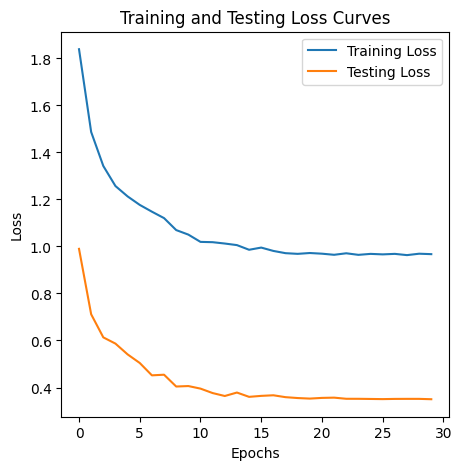

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Testing Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Testing Loss Curves")
plt.legend()
plt.show()